In [1]:
!pip install PyMySQL
!pip install SQLAlchemy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


**Lecture des données contenu dans la base Mysql. Ici on a choisi le symbol BTCEUR avec une granularité de 1h**

In [17]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# récupération des variables d'environnement
host_opa=os.getenv('host')
user_opa=os.getenv('user')
password_opa=os.getenv('password')
database_opa=os.getenv('database')


my_conn = create_engine("mysql+pymysql://{username}:{pw}@{hostname}/{db}".format(hostname=host_opa, db=database_opa, username=user_opa, pw=password_opa))

df =pd.read_sql('SELECT close_time, close FROM history_Data WHERE symbol_id =1 AND  granularity_id =1',con=my_conn)

In [18]:
print(len(df))
df.head()
#df.dtypes

36066


,close_time,close
0,2020-01-03 10:00:00,6506.73
1,2020-01-03 11:00:00,6551.62
2,2020-01-03 12:00:00,6565.43
3,2020-01-03 13:00:00,6581.57
4,2020-01-03 14:00:00,6581.57


**Instalation et import des librairies**

In [1]:
import numpy as np
import datetime

#libraire pourb les graphes
# ==============================================================================
#!pip install matplotlib
#!pip install plotly
#!pip install seaborn
#!pip install statsmodels
#!pip install skforecast
#!pip install lightgbm
#!pip install sklearn

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
#from statsmodels.graphics.tsaplots import plot_acf
#from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('ggplot')
plt.style.use('ggplot')

# Librairies pour le model
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

**Indexation et application de la methode asfreq**

In [20]:

df = df.set_index('close_time')

#df = df.asfreq('H')
df = df.asfreq(freq='H', method='bfill')
df = df.sort_index()

print(f'valeurs manquantes: {df.isnull().any(axis=1).mean()}')
print(len(df))
df.head()

valeurs manquantes: 0.0
36098


,close
close_time,
2020-01-03 10:00:00,6506.73
2020-01-03 11:00:00,6551.62
2020-01-03 12:00:00,6565.43
2020-01-03 13:00:00,6581.57
2020-01-03 14:00:00,6581.57


**Choix des dates pour la separation des données en jeu d'entrainement et de test**

In [21]:
# delimitation des dates de train et de test
# ==============================================================================
date_debut_train = '2020-01-03 10:00:00'
date_fin_train = '2023-06-30 23:00:00'
date_debut_test='2023-07-01 00:00:00'
df.head()

,close
close_time,
2020-01-03 10:00:00,6506.73
2020-01-03 11:00:00,6551.62
2020-01-03 12:00:00,6565.43
2020-01-03 13:00:00,6581.57
2020-01-03 14:00:00,6581.57


**Entrainement du Model avec lags allant de 1 à 1000 et prédictions avec backtesting**

In [17]:
# Application de model et prediction avec différent lags
# ==============================================================================
lags = []
for i in range(1, 1001):
    lags.append(i)

metrics = []
predictions_list = []

for lag in lags:
    
    # instanciation
    forecaster = ForecasterAutoreg(
                     regressor     = LGBMRegressor(random_state=213),
                     lags          = lag,
                     transformer_y = None
                 )
    
    # predictions  avec 1 step
    metric, predictions = backtesting_forecaster(
                              forecaster         = forecaster,
                              y                  = df.loc[date_debut_train:, 'close'],
                              initial_train_size = len(df.loc[date_debut_train:date_fin_train, 'close']),
                              fixed_train_size   = True,
                              steps              = 1,
                              refit              = False,
                              metric             = 'mean_absolute_error',
                              verbose            = False
                          )
    
    metrics.append(metric)
    predictions_list.append(predictions)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 30589, number of used features: 1
[LightGBM] [Info] Start training from score 25219.338184


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 30588, number of used features: 2
[LightGBM] [Info] Start training from score 25219.948479


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 30587, number of used features: 3
[LightGBM] [Info] Start training from score 25220.558363


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 30586, number of used features: 4
[LightGBM] [Info] Start training from score 25221.167759


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 30585, number of used features: 5
[LightGBM] [Info] Start training from score 25221.777195


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 30584, number of used features: 6
[LightGBM] [Info] Start training from score 25222.386671


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 30583, number of used features: 7
[LightGBM] [Info] Start training from score 25222.998663


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 30582, number of used features: 8
[LightGBM] [Info] Start training from score 25223.610696


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 30581, number of used features: 9
[LightGBM] [Info] Start training from score 25224.219698


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 30580, number of used features: 10
[LightGBM] [Info] Start training from score 25224.829811


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 30579, number of used features: 11
[LightGBM] [Info] Start training from score 25225.439741


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 30578, number of used features: 12
[LightGBM] [Info] Start training from score 25226.050481


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 30577, number of used features: 13
[LightGBM] [Info] Start training from score 25226.661486


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 30576, number of used features: 14
[LightGBM] [Info] Start training from score 25227.272531


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 30575, number of used features: 15
[LightGBM] [Info] Start training from score 25227.884500


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 30574, number of used features: 16
[LightGBM] [Info] Start training from score 25228.494795


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 30573, number of used features: 17
[LightGBM] [Info] Start training from score 25229.105443


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 30572, number of used features: 18
[LightGBM] [Info] Start training from score 25229.716436


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 30571, number of used features: 19
[LightGBM] [Info] Start training from score 25230.327468


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 30570, number of used features: 20
[LightGBM] [Info] Start training from score 25230.939072


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 30569, number of used features: 21
[LightGBM] [Info] Start training from score 25231.550716


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 30568, number of used features: 22
[LightGBM] [Info] Start training from score 25232.161085


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 30567, number of used features: 23
[LightGBM] [Info] Start training from score 25232.771494


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 30566, number of used features: 24
[LightGBM] [Info] Start training from score 25233.381943


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 30565, number of used features: 25
[LightGBM] [Info] Start training from score 25233.992432


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 30564, number of used features: 26
[LightGBM] [Info] Start training from score 25234.602960


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 30563, number of used features: 27
[LightGBM] [Info] Start training from score 25235.213121


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 30562, number of used features: 28
[LightGBM] [Info] Start training from score 25235.824842


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 30561, number of used features: 29
[LightGBM] [Info] Start training from score 25236.435892


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 30560, number of used features: 30
[LightGBM] [Info] Start training from score 25237.047523


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 30559, number of used features: 31
[LightGBM] [Info] Start training from score 25237.659030


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 30558, number of used features: 32
[LightGBM] [Info] Start training from score 25238.271204


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8415
[LightGBM] [Info] Number of data points in the train set: 30557, number of used features: 33
[LightGBM] [Info] Start training from score 25238.883418


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 30556, number of used features: 34
[LightGBM] [Info] Start training from score 25239.495673


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 30555, number of used features: 35
[LightGBM] [Info] Start training from score 25240.107967


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 30554, number of used features: 36
[LightGBM] [Info] Start training from score 25240.720140


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9435
[LightGBM] [Info] Number of data points in the train set: 30553, number of used features: 37
[LightGBM] [Info] Start training from score 25241.330807


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 30552, number of used features: 38
[LightGBM] [Info] Start training from score 25241.941999


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9945
[LightGBM] [Info] Number of data points in the train set: 30551, number of used features: 39
[LightGBM] [Info] Start training from score 25242.553232


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 30550, number of used features: 40
[LightGBM] [Info] Start training from score 25243.164504


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 30549, number of used features: 41
[LightGBM] [Info] Start training from score 25243.774977


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 30548, number of used features: 42
[LightGBM] [Info] Start training from score 25244.382038


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10965
[LightGBM] [Info] Number of data points in the train set: 30547, number of used features: 43
[LightGBM] [Info] Start training from score 25244.989841


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11220
[LightGBM] [Info] Number of data points in the train set: 30546, number of used features: 44
[LightGBM] [Info] Start training from score 25245.597677


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11475
[LightGBM] [Info] Number of data points in the train set: 30545, number of used features: 45
[LightGBM] [Info] Start training from score 25246.205775


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 30544, number of used features: 46
[LightGBM] [Info] Start training from score 25246.813912


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11985
[LightGBM] [Info] Number of data points in the train set: 30543, number of used features: 47
[LightGBM] [Info] Start training from score 25247.421663


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 30542, number of used features: 48
[LightGBM] [Info] Start training from score 25248.029266


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12495
[LightGBM] [Info] Number of data points in the train set: 30541, number of used features: 49
[LightGBM] [Info] Start training from score 25248.637922


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 30540, number of used features: 50
[LightGBM] [Info] Start training from score 25249.246635


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 30539, number of used features: 51
[LightGBM] [Info] Start training from score 25249.856519


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 30538, number of used features: 52
[LightGBM] [Info] Start training from score 25250.465413


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13515
[LightGBM] [Info] Number of data points in the train set: 30537, number of used features: 53
[LightGBM] [Info] Start training from score 25251.074196


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13770
[LightGBM] [Info] Number of data points in the train set: 30536, number of used features: 54
[LightGBM] [Info] Start training from score 25251.682631


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 30535, number of used features: 55
[LightGBM] [Info] Start training from score 25252.291775


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 30534, number of used features: 56
[LightGBM] [Info] Start training from score 25252.899892


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14535
[LightGBM] [Info] Number of data points in the train set: 30533, number of used features: 57
[LightGBM] [Info] Start training from score 25253.508285


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14790
[LightGBM] [Info] Number of data points in the train set: 30532, number of used features: 58
[LightGBM] [Info] Start training from score 25254.116717


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15045
[LightGBM] [Info] Number of data points in the train set: 30531, number of used features: 59
[LightGBM] [Info] Start training from score 25254.726942


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15300
[LightGBM] [Info] Number of data points in the train set: 30530, number of used features: 60
[LightGBM] [Info] Start training from score 25255.334958


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15555
[LightGBM] [Info] Number of data points in the train set: 30529, number of used features: 61
[LightGBM] [Info] Start training from score 25255.943767


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15810
[LightGBM] [Info] Number of data points in the train set: 30528, number of used features: 62
[LightGBM] [Info] Start training from score 25256.554826


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16065
[LightGBM] [Info] Number of data points in the train set: 30527, number of used features: 63
[LightGBM] [Info] Start training from score 25257.166518


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 30526, number of used features: 64
[LightGBM] [Info] Start training from score 25257.778068


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16575
[LightGBM] [Info] Number of data points in the train set: 30525, number of used features: 65
[LightGBM] [Info] Start training from score 25258.389324


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16830
[LightGBM] [Info] Number of data points in the train set: 30524, number of used features: 66
[LightGBM] [Info] Start training from score 25259.000160


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17085
[LightGBM] [Info] Number of data points in the train set: 30523, number of used features: 67
[LightGBM] [Info] Start training from score 25259.606575


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17340
[LightGBM] [Info] Number of data points in the train set: 30522, number of used features: 68
[LightGBM] [Info] Start training from score 25260.213874


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17595
[LightGBM] [Info] Number of data points in the train set: 30521, number of used features: 69
[LightGBM] [Info] Start training from score 25260.820518


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 30520, number of used features: 70
[LightGBM] [Info] Start training from score 25261.427202


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18105
[LightGBM] [Info] Number of data points in the train set: 30519, number of used features: 71
[LightGBM] [Info] Start training from score 25262.033926


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18360
[LightGBM] [Info] Number of data points in the train set: 30518, number of used features: 72
[LightGBM] [Info] Start training from score 25262.641462


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18615
[LightGBM] [Info] Number of data points in the train set: 30517, number of used features: 73
[LightGBM] [Info] Start training from score 25263.248096


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18870
[LightGBM] [Info] Number of data points in the train set: 30516, number of used features: 74
[LightGBM] [Info] Start training from score 25263.855331


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 30515, number of used features: 75
[LightGBM] [Info] Start training from score 25264.462044


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19380
[LightGBM] [Info] Number of data points in the train set: 30514, number of used features: 76
[LightGBM] [Info] Start training from score 25265.068797


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19635
[LightGBM] [Info] Number of data points in the train set: 30513, number of used features: 77
[LightGBM] [Info] Start training from score 25265.675590


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19890
[LightGBM] [Info] Number of data points in the train set: 30512, number of used features: 78
[LightGBM] [Info] Start training from score 25266.284658


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20145
[LightGBM] [Info] Number of data points in the train set: 30511, number of used features: 79
[LightGBM] [Info] Start training from score 25266.894510


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 30510, number of used features: 80
[LightGBM] [Info] Start training from score 25267.504402


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20655
[LightGBM] [Info] Number of data points in the train set: 30509, number of used features: 81
[LightGBM] [Info] Start training from score 25268.114334


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20910
[LightGBM] [Info] Number of data points in the train set: 30508, number of used features: 82
[LightGBM] [Info] Start training from score 25268.723561


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21165
[LightGBM] [Info] Number of data points in the train set: 30507, number of used features: 83
[LightGBM] [Info] Start training from score 25269.332828


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21420
[LightGBM] [Info] Number of data points in the train set: 30506, number of used features: 84
[LightGBM] [Info] Start training from score 25269.944860


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21675
[LightGBM] [Info] Number of data points in the train set: 30505, number of used features: 85
[LightGBM] [Info] Start training from score 25270.558528


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21930
[LightGBM] [Info] Number of data points in the train set: 30504, number of used features: 86
[LightGBM] [Info] Start training from score 25271.166864


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22185
[LightGBM] [Info] Number of data points in the train set: 30503, number of used features: 87
[LightGBM] [Info] Start training from score 25271.769482


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22440
[LightGBM] [Info] Number of data points in the train set: 30502, number of used features: 88
[LightGBM] [Info] Start training from score 25272.371332


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22695
[LightGBM] [Info] Number of data points in the train set: 30501, number of used features: 89
[LightGBM] [Info] Start training from score 25272.968841


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 30500, number of used features: 90
[LightGBM] [Info] Start training from score 25273.566060


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23205
[LightGBM] [Info] Number of data points in the train set: 30499, number of used features: 91
[LightGBM] [Info] Start training from score 25274.162906


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23460
[LightGBM] [Info] Number of data points in the train set: 30498, number of used features: 92
[LightGBM] [Info] Start training from score 25274.759740


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23715
[LightGBM] [Info] Number of data points in the train set: 30497, number of used features: 93
[LightGBM] [Info] Start training from score 25275.356613


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23970
[LightGBM] [Info] Number of data points in the train set: 30496, number of used features: 94
[LightGBM] [Info] Start training from score 25275.954483


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24225
[LightGBM] [Info] Number of data points in the train set: 30495, number of used features: 95
[LightGBM] [Info] Start training from score 25276.552392


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24480
[LightGBM] [Info] Number of data points in the train set: 30494, number of used features: 96
[LightGBM] [Info] Start training from score 25277.150668


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24735
[LightGBM] [Info] Number of data points in the train set: 30493, number of used features: 97
[LightGBM] [Info] Start training from score 25277.748982


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24990
[LightGBM] [Info] Number of data points in the train set: 30492, number of used features: 98
[LightGBM] [Info] Start training from score 25278.347157


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25245
[LightGBM] [Info] Number of data points in the train set: 30491, number of used features: 99
[LightGBM] [Info] Start training from score 25278.945279


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 30490, number of used features: 100
[LightGBM] [Info] Start training from score 25279.542165


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25755
[LightGBM] [Info] Number of data points in the train set: 30489, number of used features: 101
[LightGBM] [Info] Start training from score 25280.140811


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26010
[LightGBM] [Info] Number of data points in the train set: 30488, number of used features: 102
[LightGBM] [Info] Start training from score 25280.739810


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26265
[LightGBM] [Info] Number of data points in the train set: 30487, number of used features: 103
[LightGBM] [Info] Start training from score 25281.338144


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26520
[LightGBM] [Info] Number of data points in the train set: 30486, number of used features: 104
[LightGBM] [Info] Start training from score 25281.938949


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26775
[LightGBM] [Info] Number of data points in the train set: 30485, number of used features: 105
[LightGBM] [Info] Start training from score 25282.535365


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27030
[LightGBM] [Info] Number of data points in the train set: 30484, number of used features: 106
[LightGBM] [Info] Start training from score 25283.131868


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27285
[LightGBM] [Info] Number of data points in the train set: 30483, number of used features: 107
[LightGBM] [Info] Start training from score 25283.725369


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27540
[LightGBM] [Info] Number of data points in the train set: 30482, number of used features: 108
[LightGBM] [Info] Start training from score 25284.318098


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27795
[LightGBM] [Info] Number of data points in the train set: 30481, number of used features: 109
[LightGBM] [Info] Start training from score 25284.907992


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28050
[LightGBM] [Info] Number of data points in the train set: 30480, number of used features: 110
[LightGBM] [Info] Start training from score 25285.502424


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28305
[LightGBM] [Info] Number of data points in the train set: 30479, number of used features: 111
[LightGBM] [Info] Start training from score 25286.095634


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28560
[LightGBM] [Info] Number of data points in the train set: 30478, number of used features: 112
[LightGBM] [Info] Start training from score 25286.685256


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28815
[LightGBM] [Info] Number of data points in the train set: 30477, number of used features: 113
[LightGBM] [Info] Start training from score 25287.267151


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29070
[LightGBM] [Info] Number of data points in the train set: 30476, number of used features: 114
[LightGBM] [Info] Start training from score 25287.850196


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29325
[LightGBM] [Info] Number of data points in the train set: 30475, number of used features: 115
[LightGBM] [Info] Start training from score 25288.436047


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29580
[LightGBM] [Info] Number of data points in the train set: 30474, number of used features: 116
[LightGBM] [Info] Start training from score 25289.021504


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29835
[LightGBM] [Info] Number of data points in the train set: 30473, number of used features: 117
[LightGBM] [Info] Start training from score 25289.607008


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30090
[LightGBM] [Info] Number of data points in the train set: 30472, number of used features: 118
[LightGBM] [Info] Start training from score 25290.192187


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30345
[LightGBM] [Info] Number of data points in the train set: 30471, number of used features: 119
[LightGBM] [Info] Start training from score 25290.777170


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 30470, number of used features: 120
[LightGBM] [Info] Start training from score 25291.363194


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30855
[LightGBM] [Info] Number of data points in the train set: 30469, number of used features: 121
[LightGBM] [Info] Start training from score 25291.949164


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31110
[LightGBM] [Info] Number of data points in the train set: 30468, number of used features: 122
[LightGBM] [Info] Start training from score 25292.535313


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31365
[LightGBM] [Info] Number of data points in the train set: 30467, number of used features: 123
[LightGBM] [Info] Start training from score 25293.119963


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31620
[LightGBM] [Info] Number of data points in the train set: 30466, number of used features: 124
[LightGBM] [Info] Start training from score 25293.706189


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31875
[LightGBM] [Info] Number of data points in the train set: 30465, number of used features: 125
[LightGBM] [Info] Start training from score 25294.291536


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32130
[LightGBM] [Info] Number of data points in the train set: 30464, number of used features: 126
[LightGBM] [Info] Start training from score 25294.874354


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32385
[LightGBM] [Info] Number of data points in the train set: 30463, number of used features: 127
[LightGBM] [Info] Start training from score 25295.459546


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 30462, number of used features: 128
[LightGBM] [Info] Start training from score 25296.044817


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32895
[LightGBM] [Info] Number of data points in the train set: 30461, number of used features: 129
[LightGBM] [Info] Start training from score 25296.636069


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33150
[LightGBM] [Info] Number of data points in the train set: 30460, number of used features: 130
[LightGBM] [Info] Start training from score 25297.227760


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33405
[LightGBM] [Info] Number of data points in the train set: 30459, number of used features: 131
[LightGBM] [Info] Start training from score 25297.818947


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33660
[LightGBM] [Info] Number of data points in the train set: 30458, number of used features: 132
[LightGBM] [Info] Start training from score 25298.414450


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33915
[LightGBM] [Info] Number of data points in the train set: 30457, number of used features: 133
[LightGBM] [Info] Start training from score 25299.008001


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34170
[LightGBM] [Info] Number of data points in the train set: 30456, number of used features: 134
[LightGBM] [Info] Start training from score 25299.602225


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34425
[LightGBM] [Info] Number of data points in the train set: 30455, number of used features: 135
[LightGBM] [Info] Start training from score 25300.196208


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 30454, number of used features: 136
[LightGBM] [Info] Start training from score 25300.789268


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34935
[LightGBM] [Info] Number of data points in the train set: 30453, number of used features: 137
[LightGBM] [Info] Start training from score 25301.384670


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35190
[LightGBM] [Info] Number of data points in the train set: 30452, number of used features: 138
[LightGBM] [Info] Start training from score 25301.980111


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35445
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 139
[LightGBM] [Info] Start training from score 25302.574768


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35700
[LightGBM] [Info] Number of data points in the train set: 30450, number of used features: 140
[LightGBM] [Info] Start training from score 25303.170291


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35955
[LightGBM] [Info] Number of data points in the train set: 30449, number of used features: 141
[LightGBM] [Info] Start training from score 25303.766145


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36210
[LightGBM] [Info] Number of data points in the train set: 30448, number of used features: 142
[LightGBM] [Info] Start training from score 25304.362039


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36465
[LightGBM] [Info] Number of data points in the train set: 30447, number of used features: 143
[LightGBM] [Info] Start training from score 25304.958680


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36720
[LightGBM] [Info] Number of data points in the train set: 30446, number of used features: 144
[LightGBM] [Info] Start training from score 25305.554705


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36975
[LightGBM] [Info] Number of data points in the train set: 30445, number of used features: 145
[LightGBM] [Info] Start training from score 25306.151522


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37230
[LightGBM] [Info] Number of data points in the train set: 30444, number of used features: 146
[LightGBM] [Info] Start training from score 25306.749411


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37485
[LightGBM] [Info] Number of data points in the train set: 30443, number of used features: 147
[LightGBM] [Info] Start training from score 25307.347803


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37740
[LightGBM] [Info] Number of data points in the train set: 30442, number of used features: 148
[LightGBM] [Info] Start training from score 25307.946724


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37995
[LightGBM] [Info] Number of data points in the train set: 30441, number of used features: 149
[LightGBM] [Info] Start training from score 25308.544468


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 30440, number of used features: 150
[LightGBM] [Info] Start training from score 25309.140851


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38505
[LightGBM] [Info] Number of data points in the train set: 30439, number of used features: 151
[LightGBM] [Info] Start training from score 25309.738657


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38760
[LightGBM] [Info] Number of data points in the train set: 30438, number of used features: 152
[LightGBM] [Info] Start training from score 25310.336606


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39015
[LightGBM] [Info] Number of data points in the train set: 30437, number of used features: 153
[LightGBM] [Info] Start training from score 25310.936434


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39270
[LightGBM] [Info] Number of data points in the train set: 30436, number of used features: 154
[LightGBM] [Info] Start training from score 25311.536264


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39525
[LightGBM] [Info] Number of data points in the train set: 30435, number of used features: 155
[LightGBM] [Info] Start training from score 25312.135633


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39780
[LightGBM] [Info] Number of data points in the train set: 30434, number of used features: 156
[LightGBM] [Info] Start training from score 25312.732284


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40035
[LightGBM] [Info] Number of data points in the train set: 30433, number of used features: 157
[LightGBM] [Info] Start training from score 25313.332884


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 30432, number of used features: 158
[LightGBM] [Info] Start training from score 25313.934346


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40545
[LightGBM] [Info] Number of data points in the train set: 30431, number of used features: 159
[LightGBM] [Info] Start training from score 25314.535398


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40800
[LightGBM] [Info] Number of data points in the train set: 30430, number of used features: 160
[LightGBM] [Info] Start training from score 25315.136257


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41055
[LightGBM] [Info] Number of data points in the train set: 30429, number of used features: 161
[LightGBM] [Info] Start training from score 25315.736186


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41310
[LightGBM] [Info] Number of data points in the train set: 30428, number of used features: 162
[LightGBM] [Info] Start training from score 25316.336578


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41565
[LightGBM] [Info] Number of data points in the train set: 30427, number of used features: 163
[LightGBM] [Info] Start training from score 25316.937008


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41820
[LightGBM] [Info] Number of data points in the train set: 30426, number of used features: 164
[LightGBM] [Info] Start training from score 25317.538232


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42075
[LightGBM] [Info] Number of data points in the train set: 30425, number of used features: 165
[LightGBM] [Info] Start training from score 25318.140488


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42330
[LightGBM] [Info] Number of data points in the train set: 30424, number of used features: 166
[LightGBM] [Info] Start training from score 25318.743708


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42585
[LightGBM] [Info] Number of data points in the train set: 30423, number of used features: 167
[LightGBM] [Info] Start training from score 25319.347614


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42840
[LightGBM] [Info] Number of data points in the train set: 30422, number of used features: 168
[LightGBM] [Info] Start training from score 25319.951267


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43095
[LightGBM] [Info] Number of data points in the train set: 30421, number of used features: 169
[LightGBM] [Info] Start training from score 25320.555782


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43350
[LightGBM] [Info] Number of data points in the train set: 30420, number of used features: 170
[LightGBM] [Info] Start training from score 25321.160123


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43605
[LightGBM] [Info] Number of data points in the train set: 30419, number of used features: 171
[LightGBM] [Info] Start training from score 25321.762813


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43860
[LightGBM] [Info] Number of data points in the train set: 30418, number of used features: 172
[LightGBM] [Info] Start training from score 25322.363831


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44115
[LightGBM] [Info] Number of data points in the train set: 30417, number of used features: 173
[LightGBM] [Info] Start training from score 25322.962695


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44370
[LightGBM] [Info] Number of data points in the train set: 30416, number of used features: 174
[LightGBM] [Info] Start training from score 25323.562184


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44625
[LightGBM] [Info] Number of data points in the train set: 30415, number of used features: 175
[LightGBM] [Info] Start training from score 25324.159206


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44880
[LightGBM] [Info] Number of data points in the train set: 30414, number of used features: 176
[LightGBM] [Info] Start training from score 25324.753353


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45135
[LightGBM] [Info] Number of data points in the train set: 30413, number of used features: 177
[LightGBM] [Info] Start training from score 25325.349836


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45390
[LightGBM] [Info] Number of data points in the train set: 30412, number of used features: 178
[LightGBM] [Info] Start training from score 25325.946932


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45645
[LightGBM] [Info] Number of data points in the train set: 30411, number of used features: 179
[LightGBM] [Info] Start training from score 25326.543184


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45900
[LightGBM] [Info] Number of data points in the train set: 30410, number of used features: 180
[LightGBM] [Info] Start training from score 25327.138040


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46155
[LightGBM] [Info] Number of data points in the train set: 30409, number of used features: 181
[LightGBM] [Info] Start training from score 25327.731927


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46410
[LightGBM] [Info] Number of data points in the train set: 30408, number of used features: 182
[LightGBM] [Info] Start training from score 25328.326579


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46665
[LightGBM] [Info] Number of data points in the train set: 30407, number of used features: 183
[LightGBM] [Info] Start training from score 25328.921809


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46920
[LightGBM] [Info] Number of data points in the train set: 30406, number of used features: 184
[LightGBM] [Info] Start training from score 25329.513104


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47175
[LightGBM] [Info] Number of data points in the train set: 30405, number of used features: 185
[LightGBM] [Info] Start training from score 25330.104438


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47430
[LightGBM] [Info] Number of data points in the train set: 30404, number of used features: 186
[LightGBM] [Info] Start training from score 25330.694205


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47685
[LightGBM] [Info] Number of data points in the train set: 30403, number of used features: 187
[LightGBM] [Info] Start training from score 25331.285437


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47940
[LightGBM] [Info] Number of data points in the train set: 30402, number of used features: 188
[LightGBM] [Info] Start training from score 25331.876707


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48195
[LightGBM] [Info] Number of data points in the train set: 30401, number of used features: 189
[LightGBM] [Info] Start training from score 25332.470286


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 30400, number of used features: 190
[LightGBM] [Info] Start training from score 25333.063904


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48705
[LightGBM] [Info] Number of data points in the train set: 30399, number of used features: 191
[LightGBM] [Info] Start training from score 25333.657561


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48960
[LightGBM] [Info] Number of data points in the train set: 30398, number of used features: 192
[LightGBM] [Info] Start training from score 25334.251257


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49215
[LightGBM] [Info] Number of data points in the train set: 30397, number of used features: 193
[LightGBM] [Info] Start training from score 25334.845120


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49470
[LightGBM] [Info] Number of data points in the train set: 30396, number of used features: 194
[LightGBM] [Info] Start training from score 25335.437977


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49725
[LightGBM] [Info] Number of data points in the train set: 30395, number of used features: 195
[LightGBM] [Info] Start training from score 25336.033165


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49980
[LightGBM] [Info] Number of data points in the train set: 30394, number of used features: 196
[LightGBM] [Info] Start training from score 25336.629169


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50235
[LightGBM] [Info] Number of data points in the train set: 30393, number of used features: 197
[LightGBM] [Info] Start training from score 25337.224976


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50490
[LightGBM] [Info] Number of data points in the train set: 30392, number of used features: 198
[LightGBM] [Info] Start training from score 25337.819482


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50745
[LightGBM] [Info] Number of data points in the train set: 30391, number of used features: 199
[LightGBM] [Info] Start training from score 25338.413523


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 30390, number of used features: 200
[LightGBM] [Info] Start training from score 25339.008878


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51255
[LightGBM] [Info] Number of data points in the train set: 30389, number of used features: 201
[LightGBM] [Info] Start training from score 25339.600941


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51510
[LightGBM] [Info] Number of data points in the train set: 30388, number of used features: 202
[LightGBM] [Info] Start training from score 25340.192724


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51765
[LightGBM] [Info] Number of data points in the train set: 30387, number of used features: 203
[LightGBM] [Info] Start training from score 25340.785148


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52020
[LightGBM] [Info] Number of data points in the train set: 30386, number of used features: 204
[LightGBM] [Info] Start training from score 25341.377610


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52275
[LightGBM] [Info] Number of data points in the train set: 30385, number of used features: 205
[LightGBM] [Info] Start training from score 25341.969919


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52530
[LightGBM] [Info] Number of data points in the train set: 30384, number of used features: 206
[LightGBM] [Info] Start training from score 25342.564776


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52785
[LightGBM] [Info] Number of data points in the train set: 30383, number of used features: 207
[LightGBM] [Info] Start training from score 25343.159853


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53040
[LightGBM] [Info] Number of data points in the train set: 30382, number of used features: 208
[LightGBM] [Info] Start training from score 25343.756189


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53295
[LightGBM] [Info] Number of data points in the train set: 30381, number of used features: 209
[LightGBM] [Info] Start training from score 25344.352564


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53550
[LightGBM] [Info] Number of data points in the train set: 30380, number of used features: 210
[LightGBM] [Info] Start training from score 25344.947635


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53805
[LightGBM] [Info] Number of data points in the train set: 30379, number of used features: 211
[LightGBM] [Info] Start training from score 25345.542397


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54060
[LightGBM] [Info] Number of data points in the train set: 30378, number of used features: 212
[LightGBM] [Info] Start training from score 25346.137198


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54315
[LightGBM] [Info] Number of data points in the train set: 30377, number of used features: 213
[LightGBM] [Info] Start training from score 25346.732039


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54570
[LightGBM] [Info] Number of data points in the train set: 30376, number of used features: 214
[LightGBM] [Info] Start training from score 25347.326918


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54825
[LightGBM] [Info] Number of data points in the train set: 30375, number of used features: 215
[LightGBM] [Info] Start training from score 25347.920727


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55080
[LightGBM] [Info] Number of data points in the train set: 30374, number of used features: 216
[LightGBM] [Info] Start training from score 25348.514574


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55335
[LightGBM] [Info] Number of data points in the train set: 30373, number of used features: 217
[LightGBM] [Info] Start training from score 25349.108589


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55590
[LightGBM] [Info] Number of data points in the train set: 30372, number of used features: 218
[LightGBM] [Info] Start training from score 25349.702643


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55845
[LightGBM] [Info] Number of data points in the train set: 30371, number of used features: 219
[LightGBM] [Info] Start training from score 25350.296537


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56100
[LightGBM] [Info] Number of data points in the train set: 30370, number of used features: 220
[LightGBM] [Info] Start training from score 25350.891641


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56355
[LightGBM] [Info] Number of data points in the train set: 30369, number of used features: 221
[LightGBM] [Info] Start training from score 25351.487017


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56610
[LightGBM] [Info] Number of data points in the train set: 30368, number of used features: 222
[LightGBM] [Info] Start training from score 25352.081332


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56865
[LightGBM] [Info] Number of data points in the train set: 30367, number of used features: 223
[LightGBM] [Info] Start training from score 25352.675466


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 30366, number of used features: 224
[LightGBM] [Info] Start training from score 25353.269507


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57375
[LightGBM] [Info] Number of data points in the train set: 30365, number of used features: 225
[LightGBM] [Info] Start training from score 25353.864626


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57630
[LightGBM] [Info] Number of data points in the train set: 30364, number of used features: 226
[LightGBM] [Info] Start training from score 25354.459115


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57885
[LightGBM] [Info] Number of data points in the train set: 30363, number of used features: 227
[LightGBM] [Info] Start training from score 25355.054098


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58140
[LightGBM] [Info] Number of data points in the train set: 30362, number of used features: 228
[LightGBM] [Info] Start training from score 25355.648872


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58395
[LightGBM] [Info] Number of data points in the train set: 30361, number of used features: 229
[LightGBM] [Info] Start training from score 25356.243684


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58650
[LightGBM] [Info] Number of data points in the train set: 30360, number of used features: 230
[LightGBM] [Info] Start training from score 25356.838536


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58905
[LightGBM] [Info] Number of data points in the train set: 30359, number of used features: 231
[LightGBM] [Info] Start training from score 25357.432751


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59160
[LightGBM] [Info] Number of data points in the train set: 30358, number of used features: 232
[LightGBM] [Info] Start training from score 25358.025822


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59415
[LightGBM] [Info] Number of data points in the train set: 30357, number of used features: 233
[LightGBM] [Info] Start training from score 25358.619932


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59670
[LightGBM] [Info] Number of data points in the train set: 30356, number of used features: 234
[LightGBM] [Info] Start training from score 25359.214080


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59925
[LightGBM] [Info] Number of data points in the train set: 30355, number of used features: 235
[LightGBM] [Info] Start training from score 25359.808671


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 30354, number of used features: 236
[LightGBM] [Info] Start training from score 25360.403974


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60435
[LightGBM] [Info] Number of data points in the train set: 30353, number of used features: 237
[LightGBM] [Info] Start training from score 25360.999315


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60690
[LightGBM] [Info] Number of data points in the train set: 30352, number of used features: 238
[LightGBM] [Info] Start training from score 25361.595426


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 30351, number of used features: 239
[LightGBM] [Info] Start training from score 25362.192164


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61200
[LightGBM] [Info] Number of data points in the train set: 30350, number of used features: 240
[LightGBM] [Info] Start training from score 25362.789038


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61455
[LightGBM] [Info] Number of data points in the train set: 30349, number of used features: 241
[LightGBM] [Info] Start training from score 25363.384645


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61710
[LightGBM] [Info] Number of data points in the train set: 30348, number of used features: 242
[LightGBM] [Info] Start training from score 25363.980291


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61965
[LightGBM] [Info] Number of data points in the train set: 30347, number of used features: 243
[LightGBM] [Info] Start training from score 25364.575976


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62220
[LightGBM] [Info] Number of data points in the train set: 30346, number of used features: 244
[LightGBM] [Info] Start training from score 25365.172206


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62475
[LightGBM] [Info] Number of data points in the train set: 30345, number of used features: 245
[LightGBM] [Info] Start training from score 25365.769160


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62730
[LightGBM] [Info] Number of data points in the train set: 30344, number of used features: 246
[LightGBM] [Info] Start training from score 25366.365454


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62985
[LightGBM] [Info] Number of data points in the train set: 30343, number of used features: 247
[LightGBM] [Info] Start training from score 25366.961787


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63240
[LightGBM] [Info] Number of data points in the train set: 30342, number of used features: 248
[LightGBM] [Info] Start training from score 25367.558306


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63495
[LightGBM] [Info] Number of data points in the train set: 30341, number of used features: 249
[LightGBM] [Info] Start training from score 25368.154717


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63750
[LightGBM] [Info] Number of data points in the train set: 30340, number of used features: 250
[LightGBM] [Info] Start training from score 25368.751519


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64005
[LightGBM] [Info] Number of data points in the train set: 30339, number of used features: 251
[LightGBM] [Info] Start training from score 25369.347987


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64260
[LightGBM] [Info] Number of data points in the train set: 30338, number of used features: 252
[LightGBM] [Info] Start training from score 25369.944141


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64515
[LightGBM] [Info] Number of data points in the train set: 30337, number of used features: 253
[LightGBM] [Info] Start training from score 25370.540002


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64770
[LightGBM] [Info] Number of data points in the train set: 30336, number of used features: 254
[LightGBM] [Info] Start training from score 25371.135902


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65025
[LightGBM] [Info] Number of data points in the train set: 30335, number of used features: 255
[LightGBM] [Info] Start training from score 25371.731841


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65280
[LightGBM] [Info] Number of data points in the train set: 30334, number of used features: 256
[LightGBM] [Info] Start training from score 25372.327397


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65535
[LightGBM] [Info] Number of data points in the train set: 30333, number of used features: 257
[LightGBM] [Info] Start training from score 25372.918547


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65790
[LightGBM] [Info] Number of data points in the train set: 30332, number of used features: 258
[LightGBM] [Info] Start training from score 25373.505812


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66045
[LightGBM] [Info] Number of data points in the train set: 30331, number of used features: 259
[LightGBM] [Info] Start training from score 25374.092930


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66300
[LightGBM] [Info] Number of data points in the train set: 30330, number of used features: 260
[LightGBM] [Info] Start training from score 25374.679529


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66555
[LightGBM] [Info] Number of data points in the train set: 30329, number of used features: 261
[LightGBM] [Info] Start training from score 25375.263053


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66810
[LightGBM] [Info] Number of data points in the train set: 30328, number of used features: 262
[LightGBM] [Info] Start training from score 25375.847966


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67065
[LightGBM] [Info] Number of data points in the train set: 30327, number of used features: 263
[LightGBM] [Info] Start training from score 25376.432868


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67320
[LightGBM] [Info] Number of data points in the train set: 30326, number of used features: 264
[LightGBM] [Info] Start training from score 25377.016852


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67575
[LightGBM] [Info] Number of data points in the train set: 30325, number of used features: 265
[LightGBM] [Info] Start training from score 25377.602254


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67830
[LightGBM] [Info] Number of data points in the train set: 30324, number of used features: 266
[LightGBM] [Info] Start training from score 25378.185922


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68085
[LightGBM] [Info] Number of data points in the train set: 30323, number of used features: 267
[LightGBM] [Info] Start training from score 25378.770382


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68340
[LightGBM] [Info] Number of data points in the train set: 30322, number of used features: 268
[LightGBM] [Info] Start training from score 25379.354604


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68595
[LightGBM] [Info] Number of data points in the train set: 30321, number of used features: 269
[LightGBM] [Info] Start training from score 25379.938577


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68850
[LightGBM] [Info] Number of data points in the train set: 30320, number of used features: 270
[LightGBM] [Info] Start training from score 25380.521499


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69105
[LightGBM] [Info] Number of data points in the train set: 30319, number of used features: 271
[LightGBM] [Info] Start training from score 25381.099822


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69360
[LightGBM] [Info] Number of data points in the train set: 30318, number of used features: 272
[LightGBM] [Info] Start training from score 25381.678180


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69615
[LightGBM] [Info] Number of data points in the train set: 30317, number of used features: 273
[LightGBM] [Info] Start training from score 25382.259034


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69870
[LightGBM] [Info] Number of data points in the train set: 30316, number of used features: 274
[LightGBM] [Info] Start training from score 25382.835379


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70125
[LightGBM] [Info] Number of data points in the train set: 30315, number of used features: 275
[LightGBM] [Info] Start training from score 25383.413572


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70380
[LightGBM] [Info] Number of data points in the train set: 30314, number of used features: 276
[LightGBM] [Info] Start training from score 25383.991590


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70635
[LightGBM] [Info] Number of data points in the train set: 30313, number of used features: 277
[LightGBM] [Info] Start training from score 25384.571722


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70890
[LightGBM] [Info] Number of data points in the train set: 30312, number of used features: 278
[LightGBM] [Info] Start training from score 25385.149385


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 71145
[LightGBM] [Info] Number of data points in the train set: 30311, number of used features: 279
[LightGBM] [Info] Start training from score 25385.727284


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 71400
[LightGBM] [Info] Number of data points in the train set: 30310, number of used features: 280
[LightGBM] [Info] Start training from score 25386.304371


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 71655
[LightGBM] [Info] Number of data points in the train set: 30309, number of used features: 281
[LightGBM] [Info] Start training from score 25386.881041


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 71910
[LightGBM] [Info] Number of data points in the train set: 30308, number of used features: 282
[LightGBM] [Info] Start training from score 25387.459462


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72165
[LightGBM] [Info] Number of data points in the train set: 30307, number of used features: 283
[LightGBM] [Info] Start training from score 25388.035617


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72420
[LightGBM] [Info] Number of data points in the train set: 30306, number of used features: 284
[LightGBM] [Info] Start training from score 25388.614217


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72675
[LightGBM] [Info] Number of data points in the train set: 30305, number of used features: 285
[LightGBM] [Info] Start training from score 25389.197082


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72930
[LightGBM] [Info] Number of data points in the train set: 30304, number of used features: 286
[LightGBM] [Info] Start training from score 25389.779315


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73185
[LightGBM] [Info] Number of data points in the train set: 30303, number of used features: 287
[LightGBM] [Info] Start training from score 25390.360705


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73440
[LightGBM] [Info] Number of data points in the train set: 30302, number of used features: 288
[LightGBM] [Info] Start training from score 25390.943552


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73695
[LightGBM] [Info] Number of data points in the train set: 30301, number of used features: 289
[LightGBM] [Info] Start training from score 25391.525414


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73950
[LightGBM] [Info] Number of data points in the train set: 30300, number of used features: 290
[LightGBM] [Info] Start training from score 25392.103989


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74205
[LightGBM] [Info] Number of data points in the train set: 30299, number of used features: 291
[LightGBM] [Info] Start training from score 25392.682612


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74460
[LightGBM] [Info] Number of data points in the train set: 30298, number of used features: 292
[LightGBM] [Info] Start training from score 25393.261947


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74715
[LightGBM] [Info] Number of data points in the train set: 30297, number of used features: 293
[LightGBM] [Info] Start training from score 25393.840203


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74970
[LightGBM] [Info] Number of data points in the train set: 30296, number of used features: 294
[LightGBM] [Info] Start training from score 25394.415307


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75225
[LightGBM] [Info] Number of data points in the train set: 30295, number of used features: 295
[LightGBM] [Info] Start training from score 25394.991048


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75480
[LightGBM] [Info] Number of data points in the train set: 30294, number of used features: 296
[LightGBM] [Info] Start training from score 25395.570597


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75735
[LightGBM] [Info] Number of data points in the train set: 30293, number of used features: 297
[LightGBM] [Info] Start training from score 25396.148150


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75990
[LightGBM] [Info] Number of data points in the train set: 30292, number of used features: 298
[LightGBM] [Info] Start training from score 25396.726995


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76245
[LightGBM] [Info] Number of data points in the train set: 30291, number of used features: 299
[LightGBM] [Info] Start training from score 25397.306302


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 30290, number of used features: 300
[LightGBM] [Info] Start training from score 25397.886891


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76755
[LightGBM] [Info] Number of data points in the train set: 30289, number of used features: 301
[LightGBM] [Info] Start training from score 25398.464589


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77010
[LightGBM] [Info] Number of data points in the train set: 30288, number of used features: 302
[LightGBM] [Info] Start training from score 25399.042325


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77265
[LightGBM] [Info] Number of data points in the train set: 30287, number of used features: 303
[LightGBM] [Info] Start training from score 25399.619894


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77520
[LightGBM] [Info] Number of data points in the train set: 30286, number of used features: 304
[LightGBM] [Info] Start training from score 25400.198322


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77775
[LightGBM] [Info] Number of data points in the train set: 30285, number of used features: 305
[LightGBM] [Info] Start training from score 25400.778662


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78030
[LightGBM] [Info] Number of data points in the train set: 30284, number of used features: 306
[LightGBM] [Info] Start training from score 25401.361956


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78285
[LightGBM] [Info] Number of data points in the train set: 30283, number of used features: 307
[LightGBM] [Info] Start training from score 25401.945661


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78540
[LightGBM] [Info] Number of data points in the train set: 30282, number of used features: 308
[LightGBM] [Info] Start training from score 25402.529364


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78795
[LightGBM] [Info] Number of data points in the train set: 30281, number of used features: 309
[LightGBM] [Info] Start training from score 25403.113560


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79050
[LightGBM] [Info] Number of data points in the train set: 30280, number of used features: 310
[LightGBM] [Info] Start training from score 25403.695071


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79305
[LightGBM] [Info] Number of data points in the train set: 30279, number of used features: 311
[LightGBM] [Info] Start training from score 25404.277085


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79560
[LightGBM] [Info] Number of data points in the train set: 30278, number of used features: 312
[LightGBM] [Info] Start training from score 25404.859349


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79815
[LightGBM] [Info] Number of data points in the train set: 30277, number of used features: 313
[LightGBM] [Info] Start training from score 25405.442317


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80070
[LightGBM] [Info] Number of data points in the train set: 30276, number of used features: 314
[LightGBM] [Info] Start training from score 25406.026458


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80325
[LightGBM] [Info] Number of data points in the train set: 30275, number of used features: 315
[LightGBM] [Info] Start training from score 25406.610037


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80580
[LightGBM] [Info] Number of data points in the train set: 30274, number of used features: 316
[LightGBM] [Info] Start training from score 25407.191612


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80835
[LightGBM] [Info] Number of data points in the train set: 30273, number of used features: 317
[LightGBM] [Info] Start training from score 25407.773189


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81090
[LightGBM] [Info] Number of data points in the train set: 30272, number of used features: 318
[LightGBM] [Info] Start training from score 25408.357132


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81345
[LightGBM] [Info] Number of data points in the train set: 30271, number of used features: 319
[LightGBM] [Info] Start training from score 25408.939750


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81600
[LightGBM] [Info] Number of data points in the train set: 30270, number of used features: 320
[LightGBM] [Info] Start training from score 25409.521635


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81855
[LightGBM] [Info] Number of data points in the train set: 30269, number of used features: 321
[LightGBM] [Info] Start training from score 25410.105484


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82110
[LightGBM] [Info] Number of data points in the train set: 30268, number of used features: 322
[LightGBM] [Info] Start training from score 25410.686896


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82365
[LightGBM] [Info] Number of data points in the train set: 30267, number of used features: 323
[LightGBM] [Info] Start training from score 25411.268514


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82620
[LightGBM] [Info] Number of data points in the train set: 30266, number of used features: 324
[LightGBM] [Info] Start training from score 25411.851173


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82875
[LightGBM] [Info] Number of data points in the train set: 30265, number of used features: 325
[LightGBM] [Info] Start training from score 25412.432170


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83130
[LightGBM] [Info] Number of data points in the train set: 30264, number of used features: 326
[LightGBM] [Info] Start training from score 25413.013950


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83385
[LightGBM] [Info] Number of data points in the train set: 30263, number of used features: 327
[LightGBM] [Info] Start training from score 25413.595189


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83640
[LightGBM] [Info] Number of data points in the train set: 30262, number of used features: 328
[LightGBM] [Info] Start training from score 25414.175706


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83895
[LightGBM] [Info] Number of data points in the train set: 30261, number of used features: 329
[LightGBM] [Info] Start training from score 25414.757236


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84150
[LightGBM] [Info] Number of data points in the train set: 30260, number of used features: 330
[LightGBM] [Info] Start training from score 25415.338805


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84405
[LightGBM] [Info] Number of data points in the train set: 30259, number of used features: 331
[LightGBM] [Info] Start training from score 25415.919305


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84660
[LightGBM] [Info] Number of data points in the train set: 30258, number of used features: 332
[LightGBM] [Info] Start training from score 25416.499269


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84915
[LightGBM] [Info] Number of data points in the train set: 30257, number of used features: 333
[LightGBM] [Info] Start training from score 25417.078396


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85170
[LightGBM] [Info] Number of data points in the train set: 30256, number of used features: 334
[LightGBM] [Info] Start training from score 25417.655028


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85425
[LightGBM] [Info] Number of data points in the train set: 30255, number of used features: 335
[LightGBM] [Info] Start training from score 25418.232298


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85680
[LightGBM] [Info] Number of data points in the train set: 30254, number of used features: 336
[LightGBM] [Info] Start training from score 25418.808031


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85935
[LightGBM] [Info] Number of data points in the train set: 30253, number of used features: 337
[LightGBM] [Info] Start training from score 25419.383803


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86190
[LightGBM] [Info] Number of data points in the train set: 30252, number of used features: 338
[LightGBM] [Info] Start training from score 25419.958401


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86445
[LightGBM] [Info] Number of data points in the train set: 30251, number of used features: 339
[LightGBM] [Info] Start training from score 25420.533918


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86700
[LightGBM] [Info] Number of data points in the train set: 30250, number of used features: 340
[LightGBM] [Info] Start training from score 25421.109671


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86955
[LightGBM] [Info] Number of data points in the train set: 30249, number of used features: 341
[LightGBM] [Info] Start training from score 25421.687588


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87210
[LightGBM] [Info] Number of data points in the train set: 30248, number of used features: 342
[LightGBM] [Info] Start training from score 25422.265600


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87465
[LightGBM] [Info] Number of data points in the train set: 30247, number of used features: 343
[LightGBM] [Info] Start training from score 25422.843518


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87720
[LightGBM] [Info] Number of data points in the train set: 30246, number of used features: 344
[LightGBM] [Info] Start training from score 25423.420713


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87975
[LightGBM] [Info] Number of data points in the train set: 30245, number of used features: 345
[LightGBM] [Info] Start training from score 25423.996730


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88230
[LightGBM] [Info] Number of data points in the train set: 30244, number of used features: 346
[LightGBM] [Info] Start training from score 25424.572041


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88485
[LightGBM] [Info] Number of data points in the train set: 30243, number of used features: 347
[LightGBM] [Info] Start training from score 25425.146981


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88740
[LightGBM] [Info] Number of data points in the train set: 30242, number of used features: 348
[LightGBM] [Info] Start training from score 25425.723392


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88995
[LightGBM] [Info] Number of data points in the train set: 30241, number of used features: 349
[LightGBM] [Info] Start training from score 25426.300289


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89250
[LightGBM] [Info] Number of data points in the train set: 30240, number of used features: 350
[LightGBM] [Info] Start training from score 25426.875796


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89505
[LightGBM] [Info] Number of data points in the train set: 30239, number of used features: 351
[LightGBM] [Info] Start training from score 25427.451175


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89760
[LightGBM] [Info] Number of data points in the train set: 30238, number of used features: 352
[LightGBM] [Info] Start training from score 25428.026360


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90015
[LightGBM] [Info] Number of data points in the train set: 30237, number of used features: 353
[LightGBM] [Info] Start training from score 25428.600757


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90270
[LightGBM] [Info] Number of data points in the train set: 30236, number of used features: 354
[LightGBM] [Info] Start training from score 25429.175026


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90525
[LightGBM] [Info] Number of data points in the train set: 30235, number of used features: 355
[LightGBM] [Info] Start training from score 25429.750124


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90780
[LightGBM] [Info] Number of data points in the train set: 30234, number of used features: 356
[LightGBM] [Info] Start training from score 25430.325296


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91035
[LightGBM] [Info] Number of data points in the train set: 30233, number of used features: 357
[LightGBM] [Info] Start training from score 25430.902921


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91290
[LightGBM] [Info] Number of data points in the train set: 30232, number of used features: 358
[LightGBM] [Info] Start training from score 25431.480585


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91545
[LightGBM] [Info] Number of data points in the train set: 30231, number of used features: 359
[LightGBM] [Info] Start training from score 25432.058771


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91800
[LightGBM] [Info] Number of data points in the train set: 30230, number of used features: 360
[LightGBM] [Info] Start training from score 25432.636224


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92055
[LightGBM] [Info] Number of data points in the train set: 30229, number of used features: 361
[LightGBM] [Info] Start training from score 25433.214564


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92310
[LightGBM] [Info] Number of data points in the train set: 30228, number of used features: 362
[LightGBM] [Info] Start training from score 25433.791446


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92565
[LightGBM] [Info] Number of data points in the train set: 30227, number of used features: 363
[LightGBM] [Info] Start training from score 25434.368538


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92820
[LightGBM] [Info] Number of data points in the train set: 30226, number of used features: 364
[LightGBM] [Info] Start training from score 25434.946456


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93075
[LightGBM] [Info] Number of data points in the train set: 30225, number of used features: 365
[LightGBM] [Info] Start training from score 25435.523016


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93330
[LightGBM] [Info] Number of data points in the train set: 30224, number of used features: 366
[LightGBM] [Info] Start training from score 25436.098569


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93585
[LightGBM] [Info] Number of data points in the train set: 30223, number of used features: 367
[LightGBM] [Info] Start training from score 25436.673626


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93840
[LightGBM] [Info] Number of data points in the train set: 30222, number of used features: 368
[LightGBM] [Info] Start training from score 25437.250579


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94095
[LightGBM] [Info] Number of data points in the train set: 30221, number of used features: 369
[LightGBM] [Info] Start training from score 25437.826743


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94350
[LightGBM] [Info] Number of data points in the train set: 30220, number of used features: 370
[LightGBM] [Info] Start training from score 25438.402945


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94605
[LightGBM] [Info] Number of data points in the train set: 30219, number of used features: 371
[LightGBM] [Info] Start training from score 25438.980137


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94860
[LightGBM] [Info] Number of data points in the train set: 30218, number of used features: 372
[LightGBM] [Info] Start training from score 25439.556581


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 95115
[LightGBM] [Info] Number of data points in the train set: 30217, number of used features: 373
[LightGBM] [Info] Start training from score 25440.132791


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 95370
[LightGBM] [Info] Number of data points in the train set: 30216, number of used features: 374
[LightGBM] [Info] Start training from score 25440.708351


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 95625
[LightGBM] [Info] Number of data points in the train set: 30215, number of used features: 375
[LightGBM] [Info] Start training from score 25441.283917


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 95880
[LightGBM] [Info] Number of data points in the train set: 30214, number of used features: 376
[LightGBM] [Info] Start training from score 25441.859520


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 96135
[LightGBM] [Info] Number of data points in the train set: 30213, number of used features: 377
[LightGBM] [Info] Start training from score 25442.434169


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 96390
[LightGBM] [Info] Number of data points in the train set: 30212, number of used features: 378
[LightGBM] [Info] Start training from score 25443.002880


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 96645
[LightGBM] [Info] Number of data points in the train set: 30211, number of used features: 379
[LightGBM] [Info] Start training from score 25443.572258


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 96900
[LightGBM] [Info] Number of data points in the train set: 30210, number of used features: 380
[LightGBM] [Info] Start training from score 25444.140684


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97155
[LightGBM] [Info] Number of data points in the train set: 30209, number of used features: 381
[LightGBM] [Info] Start training from score 25444.709147


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97410
[LightGBM] [Info] Number of data points in the train set: 30208, number of used features: 382
[LightGBM] [Info] Start training from score 25445.279261


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97665
[LightGBM] [Info] Number of data points in the train set: 30207, number of used features: 383
[LightGBM] [Info] Start training from score 25445.851059


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97920
[LightGBM] [Info] Number of data points in the train set: 30206, number of used features: 384
[LightGBM] [Info] Start training from score 25446.423494


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98175
[LightGBM] [Info] Number of data points in the train set: 30205, number of used features: 385
[LightGBM] [Info] Start training from score 25446.995231


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98430
[LightGBM] [Info] Number of data points in the train set: 30204, number of used features: 386
[LightGBM] [Info] Start training from score 25447.567174


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 30203, number of used features: 387
[LightGBM] [Info] Start training from score 25448.139133


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98940
[LightGBM] [Info] Number of data points in the train set: 30202, number of used features: 388
[LightGBM] [Info] Start training from score 25448.723634


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99195
[LightGBM] [Info] Number of data points in the train set: 30201, number of used features: 389
[LightGBM] [Info] Start training from score 25449.308588


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99450
[LightGBM] [Info] Number of data points in the train set: 30200, number of used features: 390
[LightGBM] [Info] Start training from score 25449.894117


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99705
[LightGBM] [Info] Number of data points in the train set: 30199, number of used features: 391
[LightGBM] [Info] Start training from score 25450.479420


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99960
[LightGBM] [Info] Number of data points in the train set: 30198, number of used features: 392
[LightGBM] [Info] Start training from score 25451.064574


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100215
[LightGBM] [Info] Number of data points in the train set: 30197, number of used features: 393
[LightGBM] [Info] Start training from score 25451.649435


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100470
[LightGBM] [Info] Number of data points in the train set: 30196, number of used features: 394
[LightGBM] [Info] Start training from score 25452.233462


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100725
[LightGBM] [Info] Number of data points in the train set: 30195, number of used features: 395
[LightGBM] [Info] Start training from score 25452.818254


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100980
[LightGBM] [Info] Number of data points in the train set: 30194, number of used features: 396
[LightGBM] [Info] Start training from score 25453.402639


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 101235
[LightGBM] [Info] Number of data points in the train set: 30193, number of used features: 397
[LightGBM] [Info] Start training from score 25453.987655


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 101490
[LightGBM] [Info] Number of data points in the train set: 30192, number of used features: 398
[LightGBM] [Info] Start training from score 25454.570958


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 101745
[LightGBM] [Info] Number of data points in the train set: 30191, number of used features: 399
[LightGBM] [Info] Start training from score 25455.156651


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102000
[LightGBM] [Info] Number of data points in the train set: 30190, number of used features: 400
[LightGBM] [Info] Start training from score 25455.740190


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102255
[LightGBM] [Info] Number of data points in the train set: 30189, number of used features: 401
[LightGBM] [Info] Start training from score 25456.324169


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102510
[LightGBM] [Info] Number of data points in the train set: 30188, number of used features: 402
[LightGBM] [Info] Start training from score 25456.909048


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102765
[LightGBM] [Info] Number of data points in the train set: 30187, number of used features: 403
[LightGBM] [Info] Start training from score 25457.493648


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103020
[LightGBM] [Info] Number of data points in the train set: 30186, number of used features: 404
[LightGBM] [Info] Start training from score 25458.078286


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103275
[LightGBM] [Info] Number of data points in the train set: 30185, number of used features: 405
[LightGBM] [Info] Start training from score 25458.663508


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103530
[LightGBM] [Info] Number of data points in the train set: 30184, number of used features: 406
[LightGBM] [Info] Start training from score 25459.248770


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103785
[LightGBM] [Info] Number of data points in the train set: 30183, number of used features: 407
[LightGBM] [Info] Start training from score 25459.834257


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 104040
[LightGBM] [Info] Number of data points in the train set: 30182, number of used features: 408
[LightGBM] [Info] Start training from score 25460.419759


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 104295
[LightGBM] [Info] Number of data points in the train set: 30181, number of used features: 409
[LightGBM] [Info] Start training from score 25461.005840


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 104550
[LightGBM] [Info] Number of data points in the train set: 30180, number of used features: 410
[LightGBM] [Info] Start training from score 25461.591197


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 104805
[LightGBM] [Info] Number of data points in the train set: 30179, number of used features: 411
[LightGBM] [Info] Start training from score 25462.176424


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105060
[LightGBM] [Info] Number of data points in the train set: 30178, number of used features: 412
[LightGBM] [Info] Start training from score 25462.762082


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105315
[LightGBM] [Info] Number of data points in the train set: 30177, number of used features: 413
[LightGBM] [Info] Start training from score 25463.349279


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105570
[LightGBM] [Info] Number of data points in the train set: 30176, number of used features: 414
[LightGBM] [Info] Start training from score 25463.935783


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105825
[LightGBM] [Info] Number of data points in the train set: 30175, number of used features: 415
[LightGBM] [Info] Start training from score 25464.521166


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106080
[LightGBM] [Info] Number of data points in the train set: 30174, number of used features: 416
[LightGBM] [Info] Start training from score 25465.106588


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106335
[LightGBM] [Info] Number of data points in the train set: 30173, number of used features: 417
[LightGBM] [Info] Start training from score 25465.692196


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106590
[LightGBM] [Info] Number of data points in the train set: 30172, number of used features: 418
[LightGBM] [Info] Start training from score 25466.277697


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106845
[LightGBM] [Info] Number of data points in the train set: 30171, number of used features: 419
[LightGBM] [Info] Start training from score 25466.865446


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107100
[LightGBM] [Info] Number of data points in the train set: 30170, number of used features: 420
[LightGBM] [Info] Start training from score 25467.451610


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107355
[LightGBM] [Info] Number of data points in the train set: 30169, number of used features: 421
[LightGBM] [Info] Start training from score 25468.036232


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107610
[LightGBM] [Info] Number of data points in the train set: 30168, number of used features: 422
[LightGBM] [Info] Start training from score 25468.621633


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107865
[LightGBM] [Info] Number of data points in the train set: 30167, number of used features: 423
[LightGBM] [Info] Start training from score 25469.207536


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 108120
[LightGBM] [Info] Number of data points in the train set: 30166, number of used features: 424
[LightGBM] [Info] Start training from score 25469.793970


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 108375
[LightGBM] [Info] Number of data points in the train set: 30165, number of used features: 425
[LightGBM] [Info] Start training from score 25470.381504


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 108630
[LightGBM] [Info] Number of data points in the train set: 30164, number of used features: 426
[LightGBM] [Info] Start training from score 25470.966695


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 108885
[LightGBM] [Info] Number of data points in the train set: 30163, number of used features: 427
[LightGBM] [Info] Start training from score 25471.551800


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 109140
[LightGBM] [Info] Number of data points in the train set: 30162, number of used features: 428
[LightGBM] [Info] Start training from score 25472.136943


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 109395
[LightGBM] [Info] Number of data points in the train set: 30161, number of used features: 429
[LightGBM] [Info] Start training from score 25472.722008


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 109650
[LightGBM] [Info] Number of data points in the train set: 30160, number of used features: 430
[LightGBM] [Info] Start training from score 25473.308151


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 109905
[LightGBM] [Info] Number of data points in the train set: 30159, number of used features: 431
[LightGBM] [Info] Start training from score 25473.896175


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110160
[LightGBM] [Info] Number of data points in the train set: 30158, number of used features: 432
[LightGBM] [Info] Start training from score 25474.484387


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110415
[LightGBM] [Info] Number of data points in the train set: 30157, number of used features: 433
[LightGBM] [Info] Start training from score 25475.073260


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110670
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 434
[LightGBM] [Info] Start training from score 25475.659220


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110925
[LightGBM] [Info] Number of data points in the train set: 30155, number of used features: 435
[LightGBM] [Info] Start training from score 25476.244916


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 111180
[LightGBM] [Info] Number of data points in the train set: 30154, number of used features: 436
[LightGBM] [Info] Start training from score 25476.831657


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 111435
[LightGBM] [Info] Number of data points in the train set: 30153, number of used features: 437
[LightGBM] [Info] Start training from score 25477.419338


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 111690
[LightGBM] [Info] Number of data points in the train set: 30152, number of used features: 438
[LightGBM] [Info] Start training from score 25478.007274


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 111945
[LightGBM] [Info] Number of data points in the train set: 30151, number of used features: 439
[LightGBM] [Info] Start training from score 25478.594584


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112200
[LightGBM] [Info] Number of data points in the train set: 30150, number of used features: 440
[LightGBM] [Info] Start training from score 25479.183019


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112455
[LightGBM] [Info] Number of data points in the train set: 30149, number of used features: 441
[LightGBM] [Info] Start training from score 25479.769394


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112710
[LightGBM] [Info] Number of data points in the train set: 30148, number of used features: 442
[LightGBM] [Info] Start training from score 25480.356340


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112965
[LightGBM] [Info] Number of data points in the train set: 30147, number of used features: 443
[LightGBM] [Info] Start training from score 25480.946128


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113220
[LightGBM] [Info] Number of data points in the train set: 30146, number of used features: 444
[LightGBM] [Info] Start training from score 25481.537290


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113475
[LightGBM] [Info] Number of data points in the train set: 30145, number of used features: 445
[LightGBM] [Info] Start training from score 25482.123381


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113730
[LightGBM] [Info] Number of data points in the train set: 30144, number of used features: 446
[LightGBM] [Info] Start training from score 25482.707149


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113985
[LightGBM] [Info] Number of data points in the train set: 30143, number of used features: 447
[LightGBM] [Info] Start training from score 25483.293615


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 114240
[LightGBM] [Info] Number of data points in the train set: 30142, number of used features: 448
[LightGBM] [Info] Start training from score 25483.877177


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 114495
[LightGBM] [Info] Number of data points in the train set: 30141, number of used features: 449
[LightGBM] [Info] Start training from score 25484.459901


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 114750
[LightGBM] [Info] Number of data points in the train set: 30140, number of used features: 450
[LightGBM] [Info] Start training from score 25485.045204


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 115005
[LightGBM] [Info] Number of data points in the train set: 30139, number of used features: 451
[LightGBM] [Info] Start training from score 25485.630547


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 115260
[LightGBM] [Info] Number of data points in the train set: 30138, number of used features: 452
[LightGBM] [Info] Start training from score 25486.215927


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 115515
[LightGBM] [Info] Number of data points in the train set: 30137, number of used features: 453
[LightGBM] [Info] Start training from score 25486.801347


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 115770
[LightGBM] [Info] Number of data points in the train set: 30136, number of used features: 454
[LightGBM] [Info] Start training from score 25487.386806


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116025
[LightGBM] [Info] Number of data points in the train set: 30135, number of used features: 455
[LightGBM] [Info] Start training from score 25487.971251


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116280
[LightGBM] [Info] Number of data points in the train set: 30134, number of used features: 456
[LightGBM] [Info] Start training from score 25488.556358


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116535
[LightGBM] [Info] Number of data points in the train set: 30133, number of used features: 457
[LightGBM] [Info] Start training from score 25489.142436


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116790
[LightGBM] [Info] Number of data points in the train set: 30132, number of used features: 458
[LightGBM] [Info] Start training from score 25489.729452


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 117045
[LightGBM] [Info] Number of data points in the train set: 30131, number of used features: 459
[LightGBM] [Info] Start training from score 25490.316878


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 117300
[LightGBM] [Info] Number of data points in the train set: 30130, number of used features: 460
[LightGBM] [Info] Start training from score 25490.904874


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 117555
[LightGBM] [Info] Number of data points in the train set: 30129, number of used features: 461
[LightGBM] [Info] Start training from score 25491.493227


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 117810
[LightGBM] [Info] Number of data points in the train set: 30128, number of used features: 462
[LightGBM] [Info] Start training from score 25492.081072


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118065
[LightGBM] [Info] Number of data points in the train set: 30127, number of used features: 463
[LightGBM] [Info] Start training from score 25492.668521


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118320
[LightGBM] [Info] Number of data points in the train set: 30126, number of used features: 464
[LightGBM] [Info] Start training from score 25493.256142


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118575
[LightGBM] [Info] Number of data points in the train set: 30125, number of used features: 465
[LightGBM] [Info] Start training from score 25493.842474


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118830
[LightGBM] [Info] Number of data points in the train set: 30124, number of used features: 466
[LightGBM] [Info] Start training from score 25494.429331


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119085
[LightGBM] [Info] Number of data points in the train set: 30123, number of used features: 467
[LightGBM] [Info] Start training from score 25495.017523


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119340
[LightGBM] [Info] Number of data points in the train set: 30122, number of used features: 468
[LightGBM] [Info] Start training from score 25495.604841


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119595
[LightGBM] [Info] Number of data points in the train set: 30121, number of used features: 469
[LightGBM] [Info] Start training from score 25496.192329


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119850
[LightGBM] [Info] Number of data points in the train set: 30120, number of used features: 470
[LightGBM] [Info] Start training from score 25496.780848


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120105
[LightGBM] [Info] Number of data points in the train set: 30119, number of used features: 471
[LightGBM] [Info] Start training from score 25497.368854


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120360
[LightGBM] [Info] Number of data points in the train set: 30118, number of used features: 472
[LightGBM] [Info] Start training from score 25497.956783


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120615
[LightGBM] [Info] Number of data points in the train set: 30117, number of used features: 473
[LightGBM] [Info] Start training from score 25498.545420


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120870
[LightGBM] [Info] Number of data points in the train set: 30116, number of used features: 474
[LightGBM] [Info] Start training from score 25499.134958


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121125
[LightGBM] [Info] Number of data points in the train set: 30115, number of used features: 475
[LightGBM] [Info] Start training from score 25499.725306


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121380
[LightGBM] [Info] Number of data points in the train set: 30114, number of used features: 476
[LightGBM] [Info] Start training from score 25500.315693


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121635
[LightGBM] [Info] Number of data points in the train set: 30113, number of used features: 477
[LightGBM] [Info] Start training from score 25500.906119


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121890
[LightGBM] [Info] Number of data points in the train set: 30112, number of used features: 478
[LightGBM] [Info] Start training from score 25501.498359


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122145
[LightGBM] [Info] Number of data points in the train set: 30111, number of used features: 479
[LightGBM] [Info] Start training from score 25502.091097


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122400
[LightGBM] [Info] Number of data points in the train set: 30110, number of used features: 480
[LightGBM] [Info] Start training from score 25502.682142


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122655
[LightGBM] [Info] Number of data points in the train set: 30109, number of used features: 481
[LightGBM] [Info] Start training from score 25503.274412


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122910
[LightGBM] [Info] Number of data points in the train set: 30108, number of used features: 482
[LightGBM] [Info] Start training from score 25503.869677


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123165
[LightGBM] [Info] Number of data points in the train set: 30107, number of used features: 483
[LightGBM] [Info] Start training from score 25504.465016


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123420
[LightGBM] [Info] Number of data points in the train set: 30106, number of used features: 484
[LightGBM] [Info] Start training from score 25505.060106


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123675
[LightGBM] [Info] Number of data points in the train set: 30105, number of used features: 485
[LightGBM] [Info] Start training from score 25505.656081


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123930
[LightGBM] [Info] Number of data points in the train set: 30104, number of used features: 486
[LightGBM] [Info] Start training from score 25506.254257


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124185
[LightGBM] [Info] Number of data points in the train set: 30103, number of used features: 487
[LightGBM] [Info] Start training from score 25506.851977


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124440
[LightGBM] [Info] Number of data points in the train set: 30102, number of used features: 488
[LightGBM] [Info] Start training from score 25507.449267


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124695
[LightGBM] [Info] Number of data points in the train set: 30101, number of used features: 489
[LightGBM] [Info] Start training from score 25508.046925


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124950
[LightGBM] [Info] Number of data points in the train set: 30100, number of used features: 490
[LightGBM] [Info] Start training from score 25508.644742


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 125205
[LightGBM] [Info] Number of data points in the train set: 30099, number of used features: 491
[LightGBM] [Info] Start training from score 25509.241750


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 125460
[LightGBM] [Info] Number of data points in the train set: 30098, number of used features: 492
[LightGBM] [Info] Start training from score 25509.839206


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 125715
[LightGBM] [Info] Number of data points in the train set: 30097, number of used features: 493
[LightGBM] [Info] Start training from score 25510.435525


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 125970
[LightGBM] [Info] Number of data points in the train set: 30096, number of used features: 494
[LightGBM] [Info] Start training from score 25511.032108


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126225
[LightGBM] [Info] Number of data points in the train set: 30095, number of used features: 495
[LightGBM] [Info] Start training from score 25511.627007


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126480
[LightGBM] [Info] Number of data points in the train set: 30094, number of used features: 496
[LightGBM] [Info] Start training from score 25512.224921


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126735
[LightGBM] [Info] Number of data points in the train set: 30093, number of used features: 497
[LightGBM] [Info] Start training from score 25512.822875


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126990
[LightGBM] [Info] Number of data points in the train set: 30092, number of used features: 498
[LightGBM] [Info] Start training from score 25513.419258


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127245
[LightGBM] [Info] Number of data points in the train set: 30091, number of used features: 499
[LightGBM] [Info] Start training from score 25514.017607


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 30090, number of used features: 500
[LightGBM] [Info] Start training from score 25514.615052


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127755
[LightGBM] [Info] Number of data points in the train set: 30089, number of used features: 501
[LightGBM] [Info] Start training from score 25515.212538


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128010
[LightGBM] [Info] Number of data points in the train set: 30088, number of used features: 502
[LightGBM] [Info] Start training from score 25515.810475


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128265
[LightGBM] [Info] Number of data points in the train set: 30087, number of used features: 503
[LightGBM] [Info] Start training from score 25516.408040


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128520
[LightGBM] [Info] Number of data points in the train set: 30086, number of used features: 504
[LightGBM] [Info] Start training from score 25517.005936


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128775
[LightGBM] [Info] Number of data points in the train set: 30085, number of used features: 505
[LightGBM] [Info] Start training from score 25517.604013


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 129030
[LightGBM] [Info] Number of data points in the train set: 30084, number of used features: 506
[LightGBM] [Info] Start training from score 25518.203833


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 129285
[LightGBM] [Info] Number of data points in the train set: 30083, number of used features: 507
[LightGBM] [Info] Start training from score 25518.804961


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 129540
[LightGBM] [Info] Number of data points in the train set: 30082, number of used features: 508
[LightGBM] [Info] Start training from score 25519.401499


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 129795
[LightGBM] [Info] Number of data points in the train set: 30081, number of used features: 509
[LightGBM] [Info] Start training from score 25519.995676


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130050
[LightGBM] [Info] Number of data points in the train set: 30080, number of used features: 510
[LightGBM] [Info] Start training from score 25520.589788


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130305
[LightGBM] [Info] Number of data points in the train set: 30079, number of used features: 511
[LightGBM] [Info] Start training from score 25521.183674


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 30078, number of used features: 512
[LightGBM] [Info] Start training from score 25521.776826


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130815
[LightGBM] [Info] Number of data points in the train set: 30077, number of used features: 513
[LightGBM] [Info] Start training from score 25522.370790


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 131070
[LightGBM] [Info] Number of data points in the train set: 30076, number of used features: 514
[LightGBM] [Info] Start training from score 25522.964413


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 131325
[LightGBM] [Info] Number of data points in the train set: 30075, number of used features: 515
[LightGBM] [Info] Start training from score 25523.558261


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 131580
[LightGBM] [Info] Number of data points in the train set: 30074, number of used features: 516
[LightGBM] [Info] Start training from score 25524.151283


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 131835
[LightGBM] [Info] Number of data points in the train set: 30073, number of used features: 517
[LightGBM] [Info] Start training from score 25524.745369


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 132090
[LightGBM] [Info] Number of data points in the train set: 30072, number of used features: 518
[LightGBM] [Info] Start training from score 25525.338438


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 132345
[LightGBM] [Info] Number of data points in the train set: 30071, number of used features: 519
[LightGBM] [Info] Start training from score 25525.932804


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 132600
[LightGBM] [Info] Number of data points in the train set: 30070, number of used features: 520
[LightGBM] [Info] Start training from score 25526.528962


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 132855
[LightGBM] [Info] Number of data points in the train set: 30069, number of used features: 521
[LightGBM] [Info] Start training from score 25527.127675


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133110
[LightGBM] [Info] Number of data points in the train set: 30068, number of used features: 522
[LightGBM] [Info] Start training from score 25527.727394


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133365
[LightGBM] [Info] Number of data points in the train set: 30067, number of used features: 523
[LightGBM] [Info] Start training from score 25528.326812


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133620
[LightGBM] [Info] Number of data points in the train set: 30066, number of used features: 524
[LightGBM] [Info] Start training from score 25528.925673


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133875
[LightGBM] [Info] Number of data points in the train set: 30065, number of used features: 525
[LightGBM] [Info] Start training from score 25529.524895


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134130
[LightGBM] [Info] Number of data points in the train set: 30064, number of used features: 526
[LightGBM] [Info] Start training from score 25530.124158


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134385
[LightGBM] [Info] Number of data points in the train set: 30063, number of used features: 527
[LightGBM] [Info] Start training from score 25530.723460


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134640
[LightGBM] [Info] Number of data points in the train set: 30062, number of used features: 528
[LightGBM] [Info] Start training from score 25531.321737


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134895
[LightGBM] [Info] Number of data points in the train set: 30061, number of used features: 529
[LightGBM] [Info] Start training from score 25531.919121


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135150
[LightGBM] [Info] Number of data points in the train set: 30060, number of used features: 530
[LightGBM] [Info] Start training from score 25532.517192


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135405
[LightGBM] [Info] Number of data points in the train set: 30059, number of used features: 531
[LightGBM] [Info] Start training from score 25533.116431


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135660
[LightGBM] [Info] Number of data points in the train set: 30058, number of used features: 532
[LightGBM] [Info] Start training from score 25533.715087


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135915
[LightGBM] [Info] Number of data points in the train set: 30057, number of used features: 533
[LightGBM] [Info] Start training from score 25534.314833


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136170
[LightGBM] [Info] Number of data points in the train set: 30056, number of used features: 534
[LightGBM] [Info] Start training from score 25534.913433


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136425
[LightGBM] [Info] Number of data points in the train set: 30055, number of used features: 535
[LightGBM] [Info] Start training from score 25535.511500


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136680
[LightGBM] [Info] Number of data points in the train set: 30054, number of used features: 536
[LightGBM] [Info] Start training from score 25536.111064


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136935
[LightGBM] [Info] Number of data points in the train set: 30053, number of used features: 537
[LightGBM] [Info] Start training from score 25536.710373


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137190
[LightGBM] [Info] Number of data points in the train set: 30052, number of used features: 538
[LightGBM] [Info] Start training from score 25537.309694


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137445
[LightGBM] [Info] Number of data points in the train set: 30051, number of used features: 539
[LightGBM] [Info] Start training from score 25537.909020


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137700
[LightGBM] [Info] Number of data points in the train set: 30050, number of used features: 540
[LightGBM] [Info] Start training from score 25538.506842


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137955
[LightGBM] [Info] Number of data points in the train set: 30049, number of used features: 541
[LightGBM] [Info] Start training from score 25539.105903


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138210
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 542
[LightGBM] [Info] Start training from score 25539.703880


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138465
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 543
[LightGBM] [Info] Start training from score 25540.302123


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138720
[LightGBM] [Info] Number of data points in the train set: 30046, number of used features: 544
[LightGBM] [Info] Start training from score 25540.900104


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138975
[LightGBM] [Info] Number of data points in the train set: 30045, number of used features: 545
[LightGBM] [Info] Start training from score 25541.499212


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139230
[LightGBM] [Info] Number of data points in the train set: 30044, number of used features: 546
[LightGBM] [Info] Start training from score 25542.098314


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139485
[LightGBM] [Info] Number of data points in the train set: 30043, number of used features: 547
[LightGBM] [Info] Start training from score 25542.697456


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139740
[LightGBM] [Info] Number of data points in the train set: 30042, number of used features: 548
[LightGBM] [Info] Start training from score 25543.297185


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139995
[LightGBM] [Info] Number of data points in the train set: 30041, number of used features: 549
[LightGBM] [Info] Start training from score 25543.896954


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140250
[LightGBM] [Info] Number of data points in the train set: 30040, number of used features: 550
[LightGBM] [Info] Start training from score 25544.495171


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140505
[LightGBM] [Info] Number of data points in the train set: 30039, number of used features: 551
[LightGBM] [Info] Start training from score 25545.093427


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140760
[LightGBM] [Info] Number of data points in the train set: 30038, number of used features: 552
[LightGBM] [Info] Start training from score 25545.693170


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141015
[LightGBM] [Info] Number of data points in the train set: 30037, number of used features: 553
[LightGBM] [Info] Start training from score 25546.290433


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141270
[LightGBM] [Info] Number of data points in the train set: 30036, number of used features: 554
[LightGBM] [Info] Start training from score 25546.887735


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141525
[LightGBM] [Info] Number of data points in the train set: 30035, number of used features: 555
[LightGBM] [Info] Start training from score 25547.481938


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141780
[LightGBM] [Info] Number of data points in the train set: 30034, number of used features: 556
[LightGBM] [Info] Start training from score 25548.077579


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 142035
[LightGBM] [Info] Number of data points in the train set: 30033, number of used features: 557
[LightGBM] [Info] Start training from score 25548.674126


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 142290
[LightGBM] [Info] Number of data points in the train set: 30032, number of used features: 558
[LightGBM] [Info] Start training from score 25549.270176


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 142545
[LightGBM] [Info] Number of data points in the train set: 30031, number of used features: 559
[LightGBM] [Info] Start training from score 25549.865495


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 142800
[LightGBM] [Info] Number of data points in the train set: 30030, number of used features: 560
[LightGBM] [Info] Start training from score 25550.461954


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 143055
[LightGBM] [Info] Number of data points in the train set: 30029, number of used features: 561
[LightGBM] [Info] Start training from score 25551.057638


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 143310
[LightGBM] [Info] Number of data points in the train set: 30028, number of used features: 562
[LightGBM] [Info] Start training from score 25551.649832


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 143565
[LightGBM] [Info] Number of data points in the train set: 30027, number of used features: 563
[LightGBM] [Info] Start training from score 25552.241957


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 143820
[LightGBM] [Info] Number of data points in the train set: 30026, number of used features: 564
[LightGBM] [Info] Start training from score 25552.835007


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 144075
[LightGBM] [Info] Number of data points in the train set: 30025, number of used features: 565
[LightGBM] [Info] Start training from score 25553.428035


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 144330
[LightGBM] [Info] Number of data points in the train set: 30024, number of used features: 566
[LightGBM] [Info] Start training from score 25554.020885


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 144585
[LightGBM] [Info] Number of data points in the train set: 30023, number of used features: 567
[LightGBM] [Info] Start training from score 25554.613628


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 144840
[LightGBM] [Info] Number of data points in the train set: 30022, number of used features: 568
[LightGBM] [Info] Start training from score 25555.205246


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 145095
[LightGBM] [Info] Number of data points in the train set: 30021, number of used features: 569
[LightGBM] [Info] Start training from score 25555.796545


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 145350
[LightGBM] [Info] Number of data points in the train set: 30020, number of used features: 570
[LightGBM] [Info] Start training from score 25556.386041


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 145605
[LightGBM] [Info] Number of data points in the train set: 30019, number of used features: 571
[LightGBM] [Info] Start training from score 25556.976757


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 145860
[LightGBM] [Info] Number of data points in the train set: 30018, number of used features: 572
[LightGBM] [Info] Start training from score 25557.567512


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 146115
[LightGBM] [Info] Number of data points in the train set: 30017, number of used features: 573
[LightGBM] [Info] Start training from score 25558.159047


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 146370
[LightGBM] [Info] Number of data points in the train set: 30016, number of used features: 574
[LightGBM] [Info] Start training from score 25558.750621


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 146625
[LightGBM] [Info] Number of data points in the train set: 30015, number of used features: 575
[LightGBM] [Info] Start training from score 25559.341942


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 146880
[LightGBM] [Info] Number of data points in the train set: 30014, number of used features: 576
[LightGBM] [Info] Start training from score 25559.932325


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147135
[LightGBM] [Info] Number of data points in the train set: 30013, number of used features: 577
[LightGBM] [Info] Start training from score 25560.524819


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147390
[LightGBM] [Info] Number of data points in the train set: 30012, number of used features: 578
[LightGBM] [Info] Start training from score 25561.117690


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147645
[LightGBM] [Info] Number of data points in the train set: 30011, number of used features: 579
[LightGBM] [Info] Start training from score 25561.710601


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147900
[LightGBM] [Info] Number of data points in the train set: 30010, number of used features: 580
[LightGBM] [Info] Start training from score 25562.299128


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 148155
[LightGBM] [Info] Number of data points in the train set: 30009, number of used features: 581
[LightGBM] [Info] Start training from score 25562.889053


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 148410
[LightGBM] [Info] Number of data points in the train set: 30008, number of used features: 582
[LightGBM] [Info] Start training from score 25563.476548


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 148665
[LightGBM] [Info] Number of data points in the train set: 30007, number of used features: 583
[LightGBM] [Info] Start training from score 25564.065160


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 148920
[LightGBM] [Info] Number of data points in the train set: 30006, number of used features: 584
[LightGBM] [Info] Start training from score 25564.651805


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 149175
[LightGBM] [Info] Number of data points in the train set: 30005, number of used features: 585
[LightGBM] [Info] Start training from score 25565.238179


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 149430
[LightGBM] [Info] Number of data points in the train set: 30004, number of used features: 586
[LightGBM] [Info] Start training from score 25565.824611


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 149685
[LightGBM] [Info] Number of data points in the train set: 30003, number of used features: 587
[LightGBM] [Info] Start training from score 25566.409216


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 149940
[LightGBM] [Info] Number of data points in the train set: 30002, number of used features: 588
[LightGBM] [Info] Start training from score 25566.992653


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 150195
[LightGBM] [Info] Number of data points in the train set: 30001, number of used features: 589
[LightGBM] [Info] Start training from score 25567.574421


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 150450
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 590
[LightGBM] [Info] Start training from score 25568.155911


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 150705
[LightGBM] [Info] Number of data points in the train set: 29999, number of used features: 591
[LightGBM] [Info] Start training from score 25568.738644


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 150960
[LightGBM] [Info] Number of data points in the train set: 29998, number of used features: 592
[LightGBM] [Info] Start training from score 25569.322461


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 151215
[LightGBM] [Info] Number of data points in the train set: 29997, number of used features: 593
[LightGBM] [Info] Start training from score 25569.901708


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 151470
[LightGBM] [Info] Number of data points in the train set: 29996, number of used features: 594
[LightGBM] [Info] Start training from score 25570.478449


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 151725
[LightGBM] [Info] Number of data points in the train set: 29995, number of used features: 595
[LightGBM] [Info] Start training from score 25571.056338


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 151980
[LightGBM] [Info] Number of data points in the train set: 29994, number of used features: 596
[LightGBM] [Info] Start training from score 25571.634422


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 152235
[LightGBM] [Info] Number of data points in the train set: 29993, number of used features: 597
[LightGBM] [Info] Start training from score 25572.213609


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 152490
[LightGBM] [Info] Number of data points in the train set: 29992, number of used features: 598
[LightGBM] [Info] Start training from score 25572.794260


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 152745
[LightGBM] [Info] Number of data points in the train set: 29991, number of used features: 599
[LightGBM] [Info] Start training from score 25573.373123


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153000
[LightGBM] [Info] Number of data points in the train set: 29990, number of used features: 600
[LightGBM] [Info] Start training from score 25573.953139


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153255
[LightGBM] [Info] Number of data points in the train set: 29989, number of used features: 601
[LightGBM] [Info] Start training from score 25574.534151


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153510
[LightGBM] [Info] Number of data points in the train set: 29988, number of used features: 602
[LightGBM] [Info] Start training from score 25575.115673


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153765
[LightGBM] [Info] Number of data points in the train set: 29987, number of used features: 603
[LightGBM] [Info] Start training from score 25575.696953


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154020
[LightGBM] [Info] Number of data points in the train set: 29986, number of used features: 604
[LightGBM] [Info] Start training from score 25576.275465


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154275
[LightGBM] [Info] Number of data points in the train set: 29985, number of used features: 605
[LightGBM] [Info] Start training from score 25576.854964


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154530
[LightGBM] [Info] Number of data points in the train set: 29984, number of used features: 606
[LightGBM] [Info] Start training from score 25577.432834


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154785
[LightGBM] [Info] Number of data points in the train set: 29983, number of used features: 607
[LightGBM] [Info] Start training from score 25578.012865


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155040
[LightGBM] [Info] Number of data points in the train set: 29982, number of used features: 608
[LightGBM] [Info] Start training from score 25578.593121


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155295
[LightGBM] [Info] Number of data points in the train set: 29981, number of used features: 609
[LightGBM] [Info] Start training from score 25579.175784


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155550
[LightGBM] [Info] Number of data points in the train set: 29980, number of used features: 610
[LightGBM] [Info] Start training from score 25579.758255


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155805
[LightGBM] [Info] Number of data points in the train set: 29979, number of used features: 611
[LightGBM] [Info] Start training from score 25580.339325


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156060
[LightGBM] [Info] Number of data points in the train set: 29978, number of used features: 612
[LightGBM] [Info] Start training from score 25580.920414


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156315
[LightGBM] [Info] Number of data points in the train set: 29977, number of used features: 613
[LightGBM] [Info] Start training from score 25581.499573


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156570
[LightGBM] [Info] Number of data points in the train set: 29976, number of used features: 614
[LightGBM] [Info] Start training from score 25582.079508


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156825
[LightGBM] [Info] Number of data points in the train set: 29975, number of used features: 615
[LightGBM] [Info] Start training from score 25582.657912


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 157080
[LightGBM] [Info] Number of data points in the train set: 29974, number of used features: 616
[LightGBM] [Info] Start training from score 25583.227887


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 157335
[LightGBM] [Info] Number of data points in the train set: 29973, number of used features: 617
[LightGBM] [Info] Start training from score 25583.798422


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 157590
[LightGBM] [Info] Number of data points in the train set: 29972, number of used features: 618
[LightGBM] [Info] Start training from score 25584.370003


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 157845
[LightGBM] [Info] Number of data points in the train set: 29971, number of used features: 619
[LightGBM] [Info] Start training from score 25584.941909


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 158100
[LightGBM] [Info] Number of data points in the train set: 29970, number of used features: 620
[LightGBM] [Info] Start training from score 25585.513200


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 158355
[LightGBM] [Info] Number of data points in the train set: 29969, number of used features: 621
[LightGBM] [Info] Start training from score 25586.084999


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 158610
[LightGBM] [Info] Number of data points in the train set: 29968, number of used features: 622
[LightGBM] [Info] Start training from score 25586.656694


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 158865
[LightGBM] [Info] Number of data points in the train set: 29967, number of used features: 623
[LightGBM] [Info] Start training from score 25587.227811


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 159120
[LightGBM] [Info] Number of data points in the train set: 29966, number of used features: 624
[LightGBM] [Info] Start training from score 25587.798525


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 159375
[LightGBM] [Info] Number of data points in the train set: 29965, number of used features: 625
[LightGBM] [Info] Start training from score 25588.368485


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 159630
[LightGBM] [Info] Number of data points in the train set: 29964, number of used features: 626
[LightGBM] [Info] Start training from score 25588.939616


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 159885
[LightGBM] [Info] Number of data points in the train set: 29963, number of used features: 627
[LightGBM] [Info] Start training from score 25589.507114


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160140
[LightGBM] [Info] Number of data points in the train set: 29962, number of used features: 628
[LightGBM] [Info] Start training from score 25590.080419


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160395
[LightGBM] [Info] Number of data points in the train set: 29961, number of used features: 629
[LightGBM] [Info] Start training from score 25590.652758


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160650
[LightGBM] [Info] Number of data points in the train set: 29960, number of used features: 630
[LightGBM] [Info] Start training from score 25591.224417


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160905
[LightGBM] [Info] Number of data points in the train set: 29959, number of used features: 631
[LightGBM] [Info] Start training from score 25591.795288


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 161160
[LightGBM] [Info] Number of data points in the train set: 29958, number of used features: 632
[LightGBM] [Info] Start training from score 25592.368817


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 161415
[LightGBM] [Info] Number of data points in the train set: 29957, number of used features: 633
[LightGBM] [Info] Start training from score 25592.939763


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 161670
[LightGBM] [Info] Number of data points in the train set: 29956, number of used features: 634
[LightGBM] [Info] Start training from score 25593.511923


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 161925
[LightGBM] [Info] Number of data points in the train set: 29955, number of used features: 635
[LightGBM] [Info] Start training from score 25594.083033


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 162180
[LightGBM] [Info] Number of data points in the train set: 29954, number of used features: 636
[LightGBM] [Info] Start training from score 25594.654800


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 162435
[LightGBM] [Info] Number of data points in the train set: 29953, number of used features: 637
[LightGBM] [Info] Start training from score 25595.225072


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 162690
[LightGBM] [Info] Number of data points in the train set: 29952, number of used features: 638
[LightGBM] [Info] Start training from score 25595.796148


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 162945
[LightGBM] [Info] Number of data points in the train set: 29951, number of used features: 639
[LightGBM] [Info] Start training from score 25596.368066


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163200
[LightGBM] [Info] Number of data points in the train set: 29950, number of used features: 640
[LightGBM] [Info] Start training from score 25596.940964


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163455
[LightGBM] [Info] Number of data points in the train set: 29949, number of used features: 641
[LightGBM] [Info] Start training from score 25597.515985


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163710
[LightGBM] [Info] Number of data points in the train set: 29948, number of used features: 642
[LightGBM] [Info] Start training from score 25598.089388


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163965
[LightGBM] [Info] Number of data points in the train set: 29947, number of used features: 643
[LightGBM] [Info] Start training from score 25598.664267


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 164220
[LightGBM] [Info] Number of data points in the train set: 29946, number of used features: 644
[LightGBM] [Info] Start training from score 25599.238709


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 164475
[LightGBM] [Info] Number of data points in the train set: 29945, number of used features: 645
[LightGBM] [Info] Start training from score 25599.810733


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 164730
[LightGBM] [Info] Number of data points in the train set: 29944, number of used features: 646
[LightGBM] [Info] Start training from score 25600.383157


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 164985
[LightGBM] [Info] Number of data points in the train set: 29943, number of used features: 647
[LightGBM] [Info] Start training from score 25600.955620


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 165240
[LightGBM] [Info] Number of data points in the train set: 29942, number of used features: 648
[LightGBM] [Info] Start training from score 25601.526756


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 165495
[LightGBM] [Info] Number of data points in the train set: 29941, number of used features: 649
[LightGBM] [Info] Start training from score 25602.098117


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 165750
[LightGBM] [Info] Number of data points in the train set: 29940, number of used features: 650
[LightGBM] [Info] Start training from score 25602.671307


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 166005
[LightGBM] [Info] Number of data points in the train set: 29939, number of used features: 651
[LightGBM] [Info] Start training from score 25603.243542


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 166260
[LightGBM] [Info] Number of data points in the train set: 29938, number of used features: 652
[LightGBM] [Info] Start training from score 25603.815833


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 166515
[LightGBM] [Info] Number of data points in the train set: 29937, number of used features: 653
[LightGBM] [Info] Start training from score 25604.387350


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 166770
[LightGBM] [Info] Number of data points in the train set: 29936, number of used features: 654
[LightGBM] [Info] Start training from score 25604.958086


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 167025
[LightGBM] [Info] Number of data points in the train set: 29935, number of used features: 655
[LightGBM] [Info] Start training from score 25605.530066


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 167280
[LightGBM] [Info] Number of data points in the train set: 29934, number of used features: 656
[LightGBM] [Info] Start training from score 25606.101952


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 167535
[LightGBM] [Info] Number of data points in the train set: 29933, number of used features: 657
[LightGBM] [Info] Start training from score 25606.675359


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 167790
[LightGBM] [Info] Number of data points in the train set: 29932, number of used features: 658
[LightGBM] [Info] Start training from score 25607.243557


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168045
[LightGBM] [Info] Number of data points in the train set: 29931, number of used features: 659
[LightGBM] [Info] Start training from score 25607.811655


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168300
[LightGBM] [Info] Number of data points in the train set: 29930, number of used features: 660
[LightGBM] [Info] Start training from score 25608.379430


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168555
[LightGBM] [Info] Number of data points in the train set: 29929, number of used features: 661
[LightGBM] [Info] Start training from score 25608.945951


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168810
[LightGBM] [Info] Number of data points in the train set: 29928, number of used features: 662
[LightGBM] [Info] Start training from score 25609.514312


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169065
[LightGBM] [Info] Number of data points in the train set: 29927, number of used features: 663
[LightGBM] [Info] Start training from score 25610.081677


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169320
[LightGBM] [Info] Number of data points in the train set: 29926, number of used features: 664
[LightGBM] [Info] Start training from score 25610.650149


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169575
[LightGBM] [Info] Number of data points in the train set: 29925, number of used features: 665
[LightGBM] [Info] Start training from score 25611.217480


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169830
[LightGBM] [Info] Number of data points in the train set: 29924, number of used features: 666
[LightGBM] [Info] Start training from score 25611.786416


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170085
[LightGBM] [Info] Number of data points in the train set: 29923, number of used features: 667
[LightGBM] [Info] Start training from score 25612.357808


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170340
[LightGBM] [Info] Number of data points in the train set: 29922, number of used features: 668
[LightGBM] [Info] Start training from score 25612.927320


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170595
[LightGBM] [Info] Number of data points in the train set: 29921, number of used features: 669
[LightGBM] [Info] Start training from score 25613.499190


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170850
[LightGBM] [Info] Number of data points in the train set: 29920, number of used features: 670
[LightGBM] [Info] Start training from score 25614.072306


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 171105
[LightGBM] [Info] Number of data points in the train set: 29919, number of used features: 671
[LightGBM] [Info] Start training from score 25614.644412


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 171360
[LightGBM] [Info] Number of data points in the train set: 29918, number of used features: 672
[LightGBM] [Info] Start training from score 25615.217883


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 171615
[LightGBM] [Info] Number of data points in the train set: 29917, number of used features: 673
[LightGBM] [Info] Start training from score 25615.790136


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 171870
[LightGBM] [Info] Number of data points in the train set: 29916, number of used features: 674
[LightGBM] [Info] Start training from score 25616.362428


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172125
[LightGBM] [Info] Number of data points in the train set: 29915, number of used features: 675
[LightGBM] [Info] Start training from score 25616.936369


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172380
[LightGBM] [Info] Number of data points in the train set: 29914, number of used features: 676
[LightGBM] [Info] Start training from score 25617.510258


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172635
[LightGBM] [Info] Number of data points in the train set: 29913, number of used features: 677
[LightGBM] [Info] Start training from score 25618.087086


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172890
[LightGBM] [Info] Number of data points in the train set: 29912, number of used features: 678
[LightGBM] [Info] Start training from score 25618.662812


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 173145
[LightGBM] [Info] Number of data points in the train set: 29911, number of used features: 679
[LightGBM] [Info] Start training from score 25619.239568


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 173400
[LightGBM] [Info] Number of data points in the train set: 29910, number of used features: 680
[LightGBM] [Info] Start training from score 25619.815756


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 173655
[LightGBM] [Info] Number of data points in the train set: 29909, number of used features: 681
[LightGBM] [Info] Start training from score 25620.392901


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 173910
[LightGBM] [Info] Number of data points in the train set: 29908, number of used features: 682
[LightGBM] [Info] Start training from score 25620.969663


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 174165
[LightGBM] [Info] Number of data points in the train set: 29907, number of used features: 683
[LightGBM] [Info] Start training from score 25621.545292


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 174420
[LightGBM] [Info] Number of data points in the train set: 29906, number of used features: 684
[LightGBM] [Info] Start training from score 25622.121308


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 174675
[LightGBM] [Info] Number of data points in the train set: 29905, number of used features: 685
[LightGBM] [Info] Start training from score 25622.697382


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 174930
[LightGBM] [Info] Number of data points in the train set: 29904, number of used features: 686
[LightGBM] [Info] Start training from score 25623.272230


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 175185
[LightGBM] [Info] Number of data points in the train set: 29903, number of used features: 687
[LightGBM] [Info] Start training from score 25623.846484


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 175440
[LightGBM] [Info] Number of data points in the train set: 29902, number of used features: 688
[LightGBM] [Info] Start training from score 25624.422114


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 175695
[LightGBM] [Info] Number of data points in the train set: 29901, number of used features: 689
[LightGBM] [Info] Start training from score 25624.997317


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 175950
[LightGBM] [Info] Number of data points in the train set: 29900, number of used features: 690
[LightGBM] [Info] Start training from score 25625.570715


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176205
[LightGBM] [Info] Number of data points in the train set: 29899, number of used features: 691
[LightGBM] [Info] Start training from score 25626.143344


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176460
[LightGBM] [Info] Number of data points in the train set: 29898, number of used features: 692
[LightGBM] [Info] Start training from score 25626.716012


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176715
[LightGBM] [Info] Number of data points in the train set: 29897, number of used features: 693
[LightGBM] [Info] Start training from score 25627.288718


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176970
[LightGBM] [Info] Number of data points in the train set: 29896, number of used features: 694
[LightGBM] [Info] Start training from score 25627.862177


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 177225
[LightGBM] [Info] Number of data points in the train set: 29895, number of used features: 695
[LightGBM] [Info] Start training from score 25628.436302


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 177480
[LightGBM] [Info] Number of data points in the train set: 29894, number of used features: 696
[LightGBM] [Info] Start training from score 25629.009414


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 177735
[LightGBM] [Info] Number of data points in the train set: 29893, number of used features: 697
[LightGBM] [Info] Start training from score 25629.583969


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 177990
[LightGBM] [Info] Number of data points in the train set: 29892, number of used features: 698
[LightGBM] [Info] Start training from score 25630.158273


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 178245
[LightGBM] [Info] Number of data points in the train set: 29891, number of used features: 699
[LightGBM] [Info] Start training from score 25630.732695


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 178500
[LightGBM] [Info] Number of data points in the train set: 29890, number of used features: 700
[LightGBM] [Info] Start training from score 25631.309345


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 178755
[LightGBM] [Info] Number of data points in the train set: 29889, number of used features: 701
[LightGBM] [Info] Start training from score 25631.886524


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 179010
[LightGBM] [Info] Number of data points in the train set: 29888, number of used features: 702
[LightGBM] [Info] Start training from score 25632.462170


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 179265
[LightGBM] [Info] Number of data points in the train set: 29887, number of used features: 703
[LightGBM] [Info] Start training from score 25633.038315


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 179520
[LightGBM] [Info] Number of data points in the train set: 29886, number of used features: 704
[LightGBM] [Info] Start training from score 25633.613445


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 179775
[LightGBM] [Info] Number of data points in the train set: 29885, number of used features: 705
[LightGBM] [Info] Start training from score 25634.188460


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 180030
[LightGBM] [Info] Number of data points in the train set: 29884, number of used features: 706
[LightGBM] [Info] Start training from score 25634.763513


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 180285
[LightGBM] [Info] Number of data points in the train set: 29883, number of used features: 707
[LightGBM] [Info] Start training from score 25635.339488


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 180540
[LightGBM] [Info] Number of data points in the train set: 29882, number of used features: 708
[LightGBM] [Info] Start training from score 25635.915802


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 180795
[LightGBM] [Info] Number of data points in the train set: 29881, number of used features: 709
[LightGBM] [Info] Start training from score 25636.491951


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 181050
[LightGBM] [Info] Number of data points in the train set: 29880, number of used features: 710
[LightGBM] [Info] Start training from score 25637.068139


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 181305
[LightGBM] [Info] Number of data points in the train set: 29879, number of used features: 711
[LightGBM] [Info] Start training from score 25637.643811


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 181560
[LightGBM] [Info] Number of data points in the train set: 29878, number of used features: 712
[LightGBM] [Info] Start training from score 25638.218526


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 181815
[LightGBM] [Info] Number of data points in the train set: 29877, number of used features: 713
[LightGBM] [Info] Start training from score 25638.794829


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 182070
[LightGBM] [Info] Number of data points in the train set: 29876, number of used features: 714
[LightGBM] [Info] Start training from score 25639.371841


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 182325
[LightGBM] [Info] Number of data points in the train set: 29875, number of used features: 715
[LightGBM] [Info] Start training from score 25639.950814


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 182580
[LightGBM] [Info] Number of data points in the train set: 29874, number of used features: 716
[LightGBM] [Info] Start training from score 25640.531250


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 182835
[LightGBM] [Info] Number of data points in the train set: 29873, number of used features: 717
[LightGBM] [Info] Start training from score 25641.109033


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 183090
[LightGBM] [Info] Number of data points in the train set: 29872, number of used features: 718
[LightGBM] [Info] Start training from score 25641.686199


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 183345
[LightGBM] [Info] Number of data points in the train set: 29871, number of used features: 719
[LightGBM] [Info] Start training from score 25642.262066


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 183600
[LightGBM] [Info] Number of data points in the train set: 29870, number of used features: 720
[LightGBM] [Info] Start training from score 25642.837686


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 183855
[LightGBM] [Info] Number of data points in the train set: 29869, number of used features: 721
[LightGBM] [Info] Start training from score 25643.413166


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 184110
[LightGBM] [Info] Number of data points in the train set: 29868, number of used features: 722
[LightGBM] [Info] Start training from score 25643.989583


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 184365
[LightGBM] [Info] Number of data points in the train set: 29867, number of used features: 723
[LightGBM] [Info] Start training from score 25644.564467


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 184620
[LightGBM] [Info] Number of data points in the train set: 29866, number of used features: 724
[LightGBM] [Info] Start training from score 25645.138516


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 184875
[LightGBM] [Info] Number of data points in the train set: 29865, number of used features: 725
[LightGBM] [Info] Start training from score 25645.713234


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185130
[LightGBM] [Info] Number of data points in the train set: 29864, number of used features: 726
[LightGBM] [Info] Start training from score 25646.287452


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185385
[LightGBM] [Info] Number of data points in the train set: 29863, number of used features: 727
[LightGBM] [Info] Start training from score 25646.861379


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185640
[LightGBM] [Info] Number of data points in the train set: 29862, number of used features: 728
[LightGBM] [Info] Start training from score 25647.434025


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185895
[LightGBM] [Info] Number of data points in the train set: 29861, number of used features: 729
[LightGBM] [Info] Start training from score 25648.007840


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186150
[LightGBM] [Info] Number of data points in the train set: 29860, number of used features: 730
[LightGBM] [Info] Start training from score 25648.581515


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186405
[LightGBM] [Info] Number of data points in the train set: 29859, number of used features: 731
[LightGBM] [Info] Start training from score 25649.155043


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186660
[LightGBM] [Info] Number of data points in the train set: 29858, number of used features: 732
[LightGBM] [Info] Start training from score 25649.728518


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186915
[LightGBM] [Info] Number of data points in the train set: 29857, number of used features: 733
[LightGBM] [Info] Start training from score 25650.302578


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 187170
[LightGBM] [Info] Number of data points in the train set: 29856, number of used features: 734
[LightGBM] [Info] Start training from score 25650.876677


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 187425
[LightGBM] [Info] Number of data points in the train set: 29855, number of used features: 735
[LightGBM] [Info] Start training from score 25651.452490


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 187680
[LightGBM] [Info] Number of data points in the train set: 29854, number of used features: 736
[LightGBM] [Info] Start training from score 25652.029375


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 187935
[LightGBM] [Info] Number of data points in the train set: 29853, number of used features: 737
[LightGBM] [Info] Start training from score 25652.604461


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 188190
[LightGBM] [Info] Number of data points in the train set: 29852, number of used features: 738
[LightGBM] [Info] Start training from score 25653.175986


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 188445
[LightGBM] [Info] Number of data points in the train set: 29851, number of used features: 739
[LightGBM] [Info] Start training from score 25653.750515


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 188700
[LightGBM] [Info] Number of data points in the train set: 29850, number of used features: 740
[LightGBM] [Info] Start training from score 25654.327695


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 188955
[LightGBM] [Info] Number of data points in the train set: 29849, number of used features: 741
[LightGBM] [Info] Start training from score 25654.904020


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 189210
[LightGBM] [Info] Number of data points in the train set: 29848, number of used features: 742
[LightGBM] [Info] Start training from score 25655.480383


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 189465
[LightGBM] [Info] Number of data points in the train set: 29847, number of used features: 743
[LightGBM] [Info] Start training from score 25656.056545


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 189720
[LightGBM] [Info] Number of data points in the train set: 29846, number of used features: 744
[LightGBM] [Info] Start training from score 25656.634671


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 189975
[LightGBM] [Info] Number of data points in the train set: 29845, number of used features: 745
[LightGBM] [Info] Start training from score 25657.210974


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 190230
[LightGBM] [Info] Number of data points in the train set: 29844, number of used features: 746
[LightGBM] [Info] Start training from score 25657.788216


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 190485
[LightGBM] [Info] Number of data points in the train set: 29843, number of used features: 747
[LightGBM] [Info] Start training from score 25658.365867


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 190740
[LightGBM] [Info] Number of data points in the train set: 29842, number of used features: 748
[LightGBM] [Info] Start training from score 25658.942541


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 190995
[LightGBM] [Info] Number of data points in the train set: 29841, number of used features: 749
[LightGBM] [Info] Start training from score 25659.518809


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191250
[LightGBM] [Info] Number of data points in the train set: 29840, number of used features: 750
[LightGBM] [Info] Start training from score 25660.096292


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191505
[LightGBM] [Info] Number of data points in the train set: 29839, number of used features: 751
[LightGBM] [Info] Start training from score 25660.672640


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191760
[LightGBM] [Info] Number of data points in the train set: 29838, number of used features: 752
[LightGBM] [Info] Start training from score 25661.252132


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192015
[LightGBM] [Info] Number of data points in the train set: 29837, number of used features: 753
[LightGBM] [Info] Start training from score 25661.832373


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192270
[LightGBM] [Info] Number of data points in the train set: 29836, number of used features: 754
[LightGBM] [Info] Start training from score 25662.410971


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192525
[LightGBM] [Info] Number of data points in the train set: 29835, number of used features: 755
[LightGBM] [Info] Start training from score 25662.990471


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192780
[LightGBM] [Info] Number of data points in the train set: 29834, number of used features: 756
[LightGBM] [Info] Start training from score 25663.569100


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193035
[LightGBM] [Info] Number of data points in the train set: 29833, number of used features: 757
[LightGBM] [Info] Start training from score 25664.146873


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193290
[LightGBM] [Info] Number of data points in the train set: 29832, number of used features: 758
[LightGBM] [Info] Start training from score 25664.726740


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193545
[LightGBM] [Info] Number of data points in the train set: 29831, number of used features: 759
[LightGBM] [Info] Start training from score 25665.305886


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193800
[LightGBM] [Info] Number of data points in the train set: 29830, number of used features: 760
[LightGBM] [Info] Start training from score 25665.884425


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194055
[LightGBM] [Info] Number of data points in the train set: 29829, number of used features: 761
[LightGBM] [Info] Start training from score 25666.461833


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194310
[LightGBM] [Info] Number of data points in the train set: 29828, number of used features: 762
[LightGBM] [Info] Start training from score 25667.041169


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194565
[LightGBM] [Info] Number of data points in the train set: 29827, number of used features: 763
[LightGBM] [Info] Start training from score 25667.620543


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194820
[LightGBM] [Info] Number of data points in the train set: 29826, number of used features: 764
[LightGBM] [Info] Start training from score 25668.200303


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195075
[LightGBM] [Info] Number of data points in the train set: 29825, number of used features: 765
[LightGBM] [Info] Start training from score 25668.780300


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195330
[LightGBM] [Info] Number of data points in the train set: 29824, number of used features: 766
[LightGBM] [Info] Start training from score 25669.359791


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195585
[LightGBM] [Info] Number of data points in the train set: 29823, number of used features: 767
[LightGBM] [Info] Start training from score 25669.940645


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 29822, number of used features: 768
[LightGBM] [Info] Start training from score 25670.520148


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196095
[LightGBM] [Info] Number of data points in the train set: 29821, number of used features: 769
[LightGBM] [Info] Start training from score 25671.101099


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196350
[LightGBM] [Info] Number of data points in the train set: 29820, number of used features: 770
[LightGBM] [Info] Start training from score 25671.684437


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196605
[LightGBM] [Info] Number of data points in the train set: 29819, number of used features: 771
[LightGBM] [Info] Start training from score 25672.267068


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196860
[LightGBM] [Info] Number of data points in the train set: 29818, number of used features: 772
[LightGBM] [Info] Start training from score 25672.849370


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197115
[LightGBM] [Info] Number of data points in the train set: 29817, number of used features: 773
[LightGBM] [Info] Start training from score 25673.433630


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197370
[LightGBM] [Info] Number of data points in the train set: 29816, number of used features: 774
[LightGBM] [Info] Start training from score 25674.017168


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197625
[LightGBM] [Info] Number of data points in the train set: 29815, number of used features: 775
[LightGBM] [Info] Start training from score 25674.600576


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197880
[LightGBM] [Info] Number of data points in the train set: 29814, number of used features: 776
[LightGBM] [Info] Start training from score 25675.182028


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 198135
[LightGBM] [Info] Number of data points in the train set: 29813, number of used features: 777
[LightGBM] [Info] Start training from score 25675.763557


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 198390
[LightGBM] [Info] Number of data points in the train set: 29812, number of used features: 778
[LightGBM] [Info] Start training from score 25676.345496


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 198645
[LightGBM] [Info] Number of data points in the train set: 29811, number of used features: 779
[LightGBM] [Info] Start training from score 25676.927587


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 198900
[LightGBM] [Info] Number of data points in the train set: 29810, number of used features: 780
[LightGBM] [Info] Start training from score 25677.510370


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 199155
[LightGBM] [Info] Number of data points in the train set: 29809, number of used features: 781
[LightGBM] [Info] Start training from score 25678.093546


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 199410
[LightGBM] [Info] Number of data points in the train set: 29808, number of used features: 782
[LightGBM] [Info] Start training from score 25678.677714


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 199665
[LightGBM] [Info] Number of data points in the train set: 29807, number of used features: 783
[LightGBM] [Info] Start training from score 25679.260433


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 199920
[LightGBM] [Info] Number of data points in the train set: 29806, number of used features: 784
[LightGBM] [Info] Start training from score 25679.843357


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 200175
[LightGBM] [Info] Number of data points in the train set: 29805, number of used features: 785
[LightGBM] [Info] Start training from score 25680.425546


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 200430
[LightGBM] [Info] Number of data points in the train set: 29804, number of used features: 786
[LightGBM] [Info] Start training from score 25681.008314


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 200685
[LightGBM] [Info] Number of data points in the train set: 29803, number of used features: 787
[LightGBM] [Info] Start training from score 25681.589967


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 200940
[LightGBM] [Info] Number of data points in the train set: 29802, number of used features: 788
[LightGBM] [Info] Start training from score 25682.172936


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 201195
[LightGBM] [Info] Number of data points in the train set: 29801, number of used features: 789
[LightGBM] [Info] Start training from score 25682.754246


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 201450
[LightGBM] [Info] Number of data points in the train set: 29800, number of used features: 790
[LightGBM] [Info] Start training from score 25683.335278


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 201705
[LightGBM] [Info] Number of data points in the train set: 29799, number of used features: 791
[LightGBM] [Info] Start training from score 25683.916363


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 201960
[LightGBM] [Info] Number of data points in the train set: 29798, number of used features: 792
[LightGBM] [Info] Start training from score 25684.497184


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202215
[LightGBM] [Info] Number of data points in the train set: 29797, number of used features: 793
[LightGBM] [Info] Start training from score 25685.078481


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202470
[LightGBM] [Info] Number of data points in the train set: 29796, number of used features: 794
[LightGBM] [Info] Start training from score 25685.659691


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202725
[LightGBM] [Info] Number of data points in the train set: 29795, number of used features: 795
[LightGBM] [Info] Start training from score 25686.237107


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202980
[LightGBM] [Info] Number of data points in the train set: 29794, number of used features: 796
[LightGBM] [Info] Start training from score 25686.814009


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 203235
[LightGBM] [Info] Number of data points in the train set: 29793, number of used features: 797
[LightGBM] [Info] Start training from score 25687.389123


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 203490
[LightGBM] [Info] Number of data points in the train set: 29792, number of used features: 798
[LightGBM] [Info] Start training from score 25687.964387


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 203745
[LightGBM] [Info] Number of data points in the train set: 29791, number of used features: 799
[LightGBM] [Info] Start training from score 25688.539157


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 204000
[LightGBM] [Info] Number of data points in the train set: 29790, number of used features: 800
[LightGBM] [Info] Start training from score 25689.113201


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 204255
[LightGBM] [Info] Number of data points in the train set: 29789, number of used features: 801
[LightGBM] [Info] Start training from score 25689.684821


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 204510
[LightGBM] [Info] Number of data points in the train set: 29788, number of used features: 802
[LightGBM] [Info] Start training from score 25690.256009


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 204765
[LightGBM] [Info] Number of data points in the train set: 29787, number of used features: 803
[LightGBM] [Info] Start training from score 25690.824657


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 205020
[LightGBM] [Info] Number of data points in the train set: 29786, number of used features: 804
[LightGBM] [Info] Start training from score 25691.393260


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 205275
[LightGBM] [Info] Number of data points in the train set: 29785, number of used features: 805
[LightGBM] [Info] Start training from score 25691.960505


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 205530
[LightGBM] [Info] Number of data points in the train set: 29784, number of used features: 806
[LightGBM] [Info] Start training from score 25692.526556


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 205785
[LightGBM] [Info] Number of data points in the train set: 29783, number of used features: 807
[LightGBM] [Info] Start training from score 25693.096176


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 206040
[LightGBM] [Info] Number of data points in the train set: 29782, number of used features: 808
[LightGBM] [Info] Start training from score 25693.665417


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 206295
[LightGBM] [Info] Number of data points in the train set: 29781, number of used features: 809
[LightGBM] [Info] Start training from score 25694.236475


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 206550
[LightGBM] [Info] Number of data points in the train set: 29780, number of used features: 810
[LightGBM] [Info] Start training from score 25694.806564


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 206805
[LightGBM] [Info] Number of data points in the train set: 29779, number of used features: 811
[LightGBM] [Info] Start training from score 25695.376746


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 207060
[LightGBM] [Info] Number of data points in the train set: 29778, number of used features: 812
[LightGBM] [Info] Start training from score 25695.946643


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 207315
[LightGBM] [Info] Number of data points in the train set: 29777, number of used features: 813
[LightGBM] [Info] Start training from score 25696.516105


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 207570
[LightGBM] [Info] Number of data points in the train set: 29776, number of used features: 814
[LightGBM] [Info] Start training from score 25697.085461


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 207825
[LightGBM] [Info] Number of data points in the train set: 29775, number of used features: 815
[LightGBM] [Info] Start training from score 25697.654259


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208080
[LightGBM] [Info] Number of data points in the train set: 29774, number of used features: 816
[LightGBM] [Info] Start training from score 25698.222137


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208335
[LightGBM] [Info] Number of data points in the train set: 29773, number of used features: 817
[LightGBM] [Info] Start training from score 25698.790825


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208590
[LightGBM] [Info] Number of data points in the train set: 29772, number of used features: 818
[LightGBM] [Info] Start training from score 25699.359796


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208845
[LightGBM] [Info] Number of data points in the train set: 29771, number of used features: 819
[LightGBM] [Info] Start training from score 25699.927766


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 209100
[LightGBM] [Info] Number of data points in the train set: 29770, number of used features: 820
[LightGBM] [Info] Start training from score 25700.495618


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 209355
[LightGBM] [Info] Number of data points in the train set: 29769, number of used features: 821
[LightGBM] [Info] Start training from score 25701.059682


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 209610
[LightGBM] [Info] Number of data points in the train set: 29768, number of used features: 822
[LightGBM] [Info] Start training from score 25701.626673


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 209865
[LightGBM] [Info] Number of data points in the train set: 29767, number of used features: 823
[LightGBM] [Info] Start training from score 25702.190077


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 210120
[LightGBM] [Info] Number of data points in the train set: 29766, number of used features: 824
[LightGBM] [Info] Start training from score 25702.753590


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 210375
[LightGBM] [Info] Number of data points in the train set: 29765, number of used features: 825
[LightGBM] [Info] Start training from score 25703.318271


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 210630
[LightGBM] [Info] Number of data points in the train set: 29764, number of used features: 826
[LightGBM] [Info] Start training from score 25703.883799


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 210885
[LightGBM] [Info] Number of data points in the train set: 29763, number of used features: 827
[LightGBM] [Info] Start training from score 25704.448889


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 211140
[LightGBM] [Info] Number of data points in the train set: 29762, number of used features: 828
[LightGBM] [Info] Start training from score 25705.014302


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 211395
[LightGBM] [Info] Number of data points in the train set: 29761, number of used features: 829
[LightGBM] [Info] Start training from score 25705.579707


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.191848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 211650
[LightGBM] [Info] Number of data points in the train set: 29760, number of used features: 830
[LightGBM] [Info] Start training from score 25706.146206


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 211905
[LightGBM] [Info] Number of data points in the train set: 29759, number of used features: 831
[LightGBM] [Info] Start training from score 25706.713495


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 212160
[LightGBM] [Info] Number of data points in the train set: 29758, number of used features: 832
[LightGBM] [Info] Start training from score 25707.279435


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 212415
[LightGBM] [Info] Number of data points in the train set: 29757, number of used features: 833
[LightGBM] [Info] Start training from score 25707.844683


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 212670
[LightGBM] [Info] Number of data points in the train set: 29756, number of used features: 834
[LightGBM] [Info] Start training from score 25708.409968


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 212925
[LightGBM] [Info] Number of data points in the train set: 29755, number of used features: 835
[LightGBM] [Info] Start training from score 25708.973551


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213180
[LightGBM] [Info] Number of data points in the train set: 29754, number of used features: 836
[LightGBM] [Info] Start training from score 25709.537704


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213435
[LightGBM] [Info] Number of data points in the train set: 29753, number of used features: 837
[LightGBM] [Info] Start training from score 25710.103103


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213690
[LightGBM] [Info] Number of data points in the train set: 29752, number of used features: 838
[LightGBM] [Info] Start training from score 25710.668984


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213945
[LightGBM] [Info] Number of data points in the train set: 29751, number of used features: 839
[LightGBM] [Info] Start training from score 25711.234902


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214200
[LightGBM] [Info] Number of data points in the train set: 29750, number of used features: 840
[LightGBM] [Info] Start training from score 25711.801330


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214455
[LightGBM] [Info] Number of data points in the train set: 29749, number of used features: 841
[LightGBM] [Info] Start training from score 25712.365780


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214710
[LightGBM] [Info] Number of data points in the train set: 29748, number of used features: 842
[LightGBM] [Info] Start training from score 25712.931449


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214965
[LightGBM] [Info] Number of data points in the train set: 29747, number of used features: 843
[LightGBM] [Info] Start training from score 25713.495627


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 215220
[LightGBM] [Info] Number of data points in the train set: 29746, number of used features: 844
[LightGBM] [Info] Start training from score 25714.057724


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 215475
[LightGBM] [Info] Number of data points in the train set: 29745, number of used features: 845
[LightGBM] [Info] Start training from score 25714.624764


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 215730
[LightGBM] [Info] Number of data points in the train set: 29744, number of used features: 846
[LightGBM] [Info] Start training from score 25715.189093


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 215985
[LightGBM] [Info] Number of data points in the train set: 29743, number of used features: 847
[LightGBM] [Info] Start training from score 25715.752287


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216240
[LightGBM] [Info] Number of data points in the train set: 29742, number of used features: 848
[LightGBM] [Info] Start training from score 25716.317774


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216495
[LightGBM] [Info] Number of data points in the train set: 29741, number of used features: 849
[LightGBM] [Info] Start training from score 25716.882530


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216750
[LightGBM] [Info] Number of data points in the train set: 29740, number of used features: 850
[LightGBM] [Info] Start training from score 25717.446561


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217005
[LightGBM] [Info] Number of data points in the train set: 29739, number of used features: 851
[LightGBM] [Info] Start training from score 25718.011365


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217260
[LightGBM] [Info] Number of data points in the train set: 29738, number of used features: 852
[LightGBM] [Info] Start training from score 25718.575697


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217515
[LightGBM] [Info] Number of data points in the train set: 29737, number of used features: 853
[LightGBM] [Info] Start training from score 25719.141476


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217770
[LightGBM] [Info] Number of data points in the train set: 29736, number of used features: 854
[LightGBM] [Info] Start training from score 25719.707428


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 218025
[LightGBM] [Info] Number of data points in the train set: 29735, number of used features: 855
[LightGBM] [Info] Start training from score 25720.271874


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 218280
[LightGBM] [Info] Number of data points in the train set: 29734, number of used features: 856
[LightGBM] [Info] Start training from score 25720.835985


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 218535
[LightGBM] [Info] Number of data points in the train set: 29733, number of used features: 857
[LightGBM] [Info] Start training from score 25721.400563


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 218790
[LightGBM] [Info] Number of data points in the train set: 29732, number of used features: 858
[LightGBM] [Info] Start training from score 25721.965421


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219045
[LightGBM] [Info] Number of data points in the train set: 29731, number of used features: 859
[LightGBM] [Info] Start training from score 25722.532260


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219300
[LightGBM] [Info] Number of data points in the train set: 29730, number of used features: 860
[LightGBM] [Info] Start training from score 25723.099668


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219555
[LightGBM] [Info] Number of data points in the train set: 29729, number of used features: 861
[LightGBM] [Info] Start training from score 25723.666570


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219810
[LightGBM] [Info] Number of data points in the train set: 29728, number of used features: 862
[LightGBM] [Info] Start training from score 25724.233509


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220065
[LightGBM] [Info] Number of data points in the train set: 29727, number of used features: 863
[LightGBM] [Info] Start training from score 25724.800210


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220320
[LightGBM] [Info] Number of data points in the train set: 29726, number of used features: 864
[LightGBM] [Info] Start training from score 25725.367440


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220575
[LightGBM] [Info] Number of data points in the train set: 29725, number of used features: 865
[LightGBM] [Info] Start training from score 25725.932297


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.334326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220830
[LightGBM] [Info] Number of data points in the train set: 29724, number of used features: 866
[LightGBM] [Info] Start training from score 25726.496657


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 221085
[LightGBM] [Info] Number of data points in the train set: 29723, number of used features: 867
[LightGBM] [Info] Start training from score 25727.060229


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 221340
[LightGBM] [Info] Number of data points in the train set: 29722, number of used features: 868
[LightGBM] [Info] Start training from score 25727.624236


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 221595
[LightGBM] [Info] Number of data points in the train set: 29721, number of used features: 869
[LightGBM] [Info] Start training from score 25728.188486


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.191915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 221850
[LightGBM] [Info] Number of data points in the train set: 29720, number of used features: 870
[LightGBM] [Info] Start training from score 25728.753793


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.191725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222105
[LightGBM] [Info] Number of data points in the train set: 29719, number of used features: 871
[LightGBM] [Info] Start training from score 25729.317302


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.193646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222360
[LightGBM] [Info] Number of data points in the train set: 29718, number of used features: 872
[LightGBM] [Info] Start training from score 25729.881561


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.191616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222615
[LightGBM] [Info] Number of data points in the train set: 29717, number of used features: 873
[LightGBM] [Info] Start training from score 25730.444534


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222870
[LightGBM] [Info] Number of data points in the train set: 29716, number of used features: 874
[LightGBM] [Info] Start training from score 25731.006873


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 223125
[LightGBM] [Info] Number of data points in the train set: 29715, number of used features: 875
[LightGBM] [Info] Start training from score 25731.569869


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 223380
[LightGBM] [Info] Number of data points in the train set: 29714, number of used features: 876
[LightGBM] [Info] Start training from score 25732.134302


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.194201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 223635
[LightGBM] [Info] Number of data points in the train set: 29713, number of used features: 877
[LightGBM] [Info] Start training from score 25732.697646


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 223890
[LightGBM] [Info] Number of data points in the train set: 29712, number of used features: 878
[LightGBM] [Info] Start training from score 25733.258024


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224145
[LightGBM] [Info] Number of data points in the train set: 29711, number of used features: 879
[LightGBM] [Info] Start training from score 25733.820168


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224400
[LightGBM] [Info] Number of data points in the train set: 29710, number of used features: 880
[LightGBM] [Info] Start training from score 25734.381896


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224655
[LightGBM] [Info] Number of data points in the train set: 29709, number of used features: 881
[LightGBM] [Info] Start training from score 25734.943949


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.191669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224910
[LightGBM] [Info] Number of data points in the train set: 29708, number of used features: 882
[LightGBM] [Info] Start training from score 25735.504474


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 225165
[LightGBM] [Info] Number of data points in the train set: 29707, number of used features: 883
[LightGBM] [Info] Start training from score 25736.061864


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 225420
[LightGBM] [Info] Number of data points in the train set: 29706, number of used features: 884
[LightGBM] [Info] Start training from score 25736.619291


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 225675
[LightGBM] [Info] Number of data points in the train set: 29705, number of used features: 885
[LightGBM] [Info] Start training from score 25737.175448


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 225930
[LightGBM] [Info] Number of data points in the train set: 29704, number of used features: 886
[LightGBM] [Info] Start training from score 25737.731642


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 226185
[LightGBM] [Info] Number of data points in the train set: 29703, number of used features: 887
[LightGBM] [Info] Start training from score 25738.287739


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.197597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 226440
[LightGBM] [Info] Number of data points in the train set: 29702, number of used features: 888
[LightGBM] [Info] Start training from score 25738.842792


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 226695
[LightGBM] [Info] Number of data points in the train set: 29701, number of used features: 889
[LightGBM] [Info] Start training from score 25739.399636


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 226950
[LightGBM] [Info] Number of data points in the train set: 29700, number of used features: 890
[LightGBM] [Info] Start training from score 25739.956100


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 227205
[LightGBM] [Info] Number of data points in the train set: 29699, number of used features: 891
[LightGBM] [Info] Start training from score 25740.511318


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 227460
[LightGBM] [Info] Number of data points in the train set: 29698, number of used features: 892
[LightGBM] [Info] Start training from score 25741.067011


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 227715
[LightGBM] [Info] Number of data points in the train set: 29697, number of used features: 893
[LightGBM] [Info] Start training from score 25741.622614


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 227970
[LightGBM] [Info] Number of data points in the train set: 29696, number of used features: 894
[LightGBM] [Info] Start training from score 25742.178563


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 228225
[LightGBM] [Info] Number of data points in the train set: 29695, number of used features: 895
[LightGBM] [Info] Start training from score 25742.735969


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 228480
[LightGBM] [Info] Number of data points in the train set: 29694, number of used features: 896
[LightGBM] [Info] Start training from score 25743.292109


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 228735
[LightGBM] [Info] Number of data points in the train set: 29693, number of used features: 897
[LightGBM] [Info] Start training from score 25743.848361


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 228990
[LightGBM] [Info] Number of data points in the train set: 29692, number of used features: 898
[LightGBM] [Info] Start training from score 25744.405706


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.194946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229245
[LightGBM] [Info] Number of data points in the train set: 29691, number of used features: 899
[LightGBM] [Info] Start training from score 25744.963673


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.199748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229500
[LightGBM] [Info] Number of data points in the train set: 29690, number of used features: 900
[LightGBM] [Info] Start training from score 25745.520436


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229755
[LightGBM] [Info] Number of data points in the train set: 29689, number of used features: 901
[LightGBM] [Info] Start training from score 25746.078951


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230010
[LightGBM] [Info] Number of data points in the train set: 29688, number of used features: 902
[LightGBM] [Info] Start training from score 25746.635690


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230265
[LightGBM] [Info] Number of data points in the train set: 29687, number of used features: 903
[LightGBM] [Info] Start training from score 25747.192481


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230520
[LightGBM] [Info] Number of data points in the train set: 29686, number of used features: 904
[LightGBM] [Info] Start training from score 25747.748406


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230775
[LightGBM] [Info] Number of data points in the train set: 29685, number of used features: 905
[LightGBM] [Info] Start training from score 25748.302673


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231030
[LightGBM] [Info] Number of data points in the train set: 29684, number of used features: 906
[LightGBM] [Info] Start training from score 25748.858463


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231285
[LightGBM] [Info] Number of data points in the train set: 29683, number of used features: 907
[LightGBM] [Info] Start training from score 25749.414434


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231540
[LightGBM] [Info] Number of data points in the train set: 29682, number of used features: 908
[LightGBM] [Info] Start training from score 25749.971185


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.194383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231795
[LightGBM] [Info] Number of data points in the train set: 29681, number of used features: 909
[LightGBM] [Info] Start training from score 25750.529056


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232050
[LightGBM] [Info] Number of data points in the train set: 29680, number of used features: 910
[LightGBM] [Info] Start training from score 25751.095120


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232305
[LightGBM] [Info] Number of data points in the train set: 29679, number of used features: 911
[LightGBM] [Info] Start training from score 25751.656997


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232560
[LightGBM] [Info] Number of data points in the train set: 29678, number of used features: 912
[LightGBM] [Info] Start training from score 25752.217603


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232815
[LightGBM] [Info] Number of data points in the train set: 29677, number of used features: 913
[LightGBM] [Info] Start training from score 25752.779764


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233070
[LightGBM] [Info] Number of data points in the train set: 29676, number of used features: 914
[LightGBM] [Info] Start training from score 25753.346422


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.195972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233325
[LightGBM] [Info] Number of data points in the train set: 29675, number of used features: 915
[LightGBM] [Info] Start training from score 25753.911093


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233580
[LightGBM] [Info] Number of data points in the train set: 29674, number of used features: 916
[LightGBM] [Info] Start training from score 25754.477276


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233835
[LightGBM] [Info] Number of data points in the train set: 29673, number of used features: 917
[LightGBM] [Info] Start training from score 25755.042187


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234090
[LightGBM] [Info] Number of data points in the train set: 29672, number of used features: 918
[LightGBM] [Info] Start training from score 25755.607226


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234345
[LightGBM] [Info] Number of data points in the train set: 29671, number of used features: 919
[LightGBM] [Info] Start training from score 25756.170288


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234600
[LightGBM] [Info] Number of data points in the train set: 29670, number of used features: 920
[LightGBM] [Info] Start training from score 25756.733239


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234855
[LightGBM] [Info] Number of data points in the train set: 29669, number of used features: 921
[LightGBM] [Info] Start training from score 25757.298366


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 235110
[LightGBM] [Info] Number of data points in the train set: 29668, number of used features: 922
[LightGBM] [Info] Start training from score 25757.862553


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 235365
[LightGBM] [Info] Number of data points in the train set: 29667, number of used features: 923
[LightGBM] [Info] Start training from score 25758.427868


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 235620
[LightGBM] [Info] Number of data points in the train set: 29666, number of used features: 924
[LightGBM] [Info] Start training from score 25758.992415


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 235875
[LightGBM] [Info] Number of data points in the train set: 29665, number of used features: 925
[LightGBM] [Info] Start training from score 25759.556083


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236130
[LightGBM] [Info] Number of data points in the train set: 29664, number of used features: 926
[LightGBM] [Info] Start training from score 25760.121610


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236385
[LightGBM] [Info] Number of data points in the train set: 29663, number of used features: 927
[LightGBM] [Info] Start training from score 25760.685942


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.297619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236640
[LightGBM] [Info] Number of data points in the train set: 29662, number of used features: 928
[LightGBM] [Info] Start training from score 25761.249943


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236895
[LightGBM] [Info] Number of data points in the train set: 29661, number of used features: 929
[LightGBM] [Info] Start training from score 25761.816722


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237150
[LightGBM] [Info] Number of data points in the train set: 29660, number of used features: 930
[LightGBM] [Info] Start training from score 25762.384142


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237405
[LightGBM] [Info] Number of data points in the train set: 29659, number of used features: 931
[LightGBM] [Info] Start training from score 25762.951202


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237660
[LightGBM] [Info] Number of data points in the train set: 29658, number of used features: 932
[LightGBM] [Info] Start training from score 25763.519231


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237915
[LightGBM] [Info] Number of data points in the train set: 29657, number of used features: 933
[LightGBM] [Info] Start training from score 25764.087402


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238170
[LightGBM] [Info] Number of data points in the train set: 29656, number of used features: 934
[LightGBM] [Info] Start training from score 25764.655383


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238425
[LightGBM] [Info] Number of data points in the train set: 29655, number of used features: 935
[LightGBM] [Info] Start training from score 25765.223564


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238680
[LightGBM] [Info] Number of data points in the train set: 29654, number of used features: 936
[LightGBM] [Info] Start training from score 25765.791405


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238935
[LightGBM] [Info] Number of data points in the train set: 29653, number of used features: 937
[LightGBM] [Info] Start training from score 25766.358779


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239190
[LightGBM] [Info] Number of data points in the train set: 29652, number of used features: 938
[LightGBM] [Info] Start training from score 25766.925190


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239445
[LightGBM] [Info] Number of data points in the train set: 29651, number of used features: 939
[LightGBM] [Info] Start training from score 25767.491429


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239700
[LightGBM] [Info] Number of data points in the train set: 29650, number of used features: 940
[LightGBM] [Info] Start training from score 25768.057537


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239955
[LightGBM] [Info] Number of data points in the train set: 29649, number of used features: 941
[LightGBM] [Info] Start training from score 25768.621806


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240210
[LightGBM] [Info] Number of data points in the train set: 29648, number of used features: 942
[LightGBM] [Info] Start training from score 25769.186169


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240465
[LightGBM] [Info] Number of data points in the train set: 29647, number of used features: 943
[LightGBM] [Info] Start training from score 25769.750760


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240720
[LightGBM] [Info] Number of data points in the train set: 29646, number of used features: 944
[LightGBM] [Info] Start training from score 25770.306140


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240975
[LightGBM] [Info] Number of data points in the train set: 29645, number of used features: 945
[LightGBM] [Info] Start training from score 25770.859465


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241230
[LightGBM] [Info] Number of data points in the train set: 29644, number of used features: 946
[LightGBM] [Info] Start training from score 25771.411451


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241485
[LightGBM] [Info] Number of data points in the train set: 29643, number of used features: 947
[LightGBM] [Info] Start training from score 25771.964189


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241740
[LightGBM] [Info] Number of data points in the train set: 29642, number of used features: 948
[LightGBM] [Info] Start training from score 25772.515549


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241995
[LightGBM] [Info] Number of data points in the train set: 29641, number of used features: 949
[LightGBM] [Info] Start training from score 25773.068353


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 242250
[LightGBM] [Info] Number of data points in the train set: 29640, number of used features: 950
[LightGBM] [Info] Start training from score 25773.621545


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 242505
[LightGBM] [Info] Number of data points in the train set: 29639, number of used features: 951
[LightGBM] [Info] Start training from score 25774.175703


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 242760
[LightGBM] [Info] Number of data points in the train set: 29638, number of used features: 952
[LightGBM] [Info] Start training from score 25774.729365


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 243015
[LightGBM] [Info] Number of data points in the train set: 29637, number of used features: 953
[LightGBM] [Info] Start training from score 25775.279818


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 243270
[LightGBM] [Info] Number of data points in the train set: 29636, number of used features: 954
[LightGBM] [Info] Start training from score 25775.830134


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 243525
[LightGBM] [Info] Number of data points in the train set: 29635, number of used features: 955
[LightGBM] [Info] Start training from score 25776.383395


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 243780
[LightGBM] [Info] Number of data points in the train set: 29634, number of used features: 956
[LightGBM] [Info] Start training from score 25776.936215


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 244035
[LightGBM] [Info] Number of data points in the train set: 29633, number of used features: 957
[LightGBM] [Info] Start training from score 25777.487966


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 244290
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 958
[LightGBM] [Info] Start training from score 25778.038605


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 244545
[LightGBM] [Info] Number of data points in the train set: 29631, number of used features: 959
[LightGBM] [Info] Start training from score 25778.589281


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 244800
[LightGBM] [Info] Number of data points in the train set: 29630, number of used features: 960
[LightGBM] [Info] Start training from score 25779.137816


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245055
[LightGBM] [Info] Number of data points in the train set: 29629, number of used features: 961
[LightGBM] [Info] Start training from score 25779.690520


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245310
[LightGBM] [Info] Number of data points in the train set: 29628, number of used features: 962
[LightGBM] [Info] Start training from score 25780.242717


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245565
[LightGBM] [Info] Number of data points in the train set: 29627, number of used features: 963
[LightGBM] [Info] Start training from score 25780.793911


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245820
[LightGBM] [Info] Number of data points in the train set: 29626, number of used features: 964
[LightGBM] [Info] Start training from score 25781.343493


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246075
[LightGBM] [Info] Number of data points in the train set: 29625, number of used features: 965
[LightGBM] [Info] Start training from score 25781.894400


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246330
[LightGBM] [Info] Number of data points in the train set: 29624, number of used features: 966
[LightGBM] [Info] Start training from score 25782.443577


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246585
[LightGBM] [Info] Number of data points in the train set: 29623, number of used features: 967
[LightGBM] [Info] Start training from score 25782.994185


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246840
[LightGBM] [Info] Number of data points in the train set: 29622, number of used features: 968
[LightGBM] [Info] Start training from score 25783.543512


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 247095
[LightGBM] [Info] Number of data points in the train set: 29621, number of used features: 969
[LightGBM] [Info] Start training from score 25784.092800


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 247350
[LightGBM] [Info] Number of data points in the train set: 29620, number of used features: 970
[LightGBM] [Info] Start training from score 25784.643158


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 247605
[LightGBM] [Info] Number of data points in the train set: 29619, number of used features: 971
[LightGBM] [Info] Start training from score 25785.193382


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 247860
[LightGBM] [Info] Number of data points in the train set: 29618, number of used features: 972
[LightGBM] [Info] Start training from score 25785.742666


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 248115
[LightGBM] [Info] Number of data points in the train set: 29617, number of used features: 973
[LightGBM] [Info] Start training from score 25786.290183


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 248370
[LightGBM] [Info] Number of data points in the train set: 29616, number of used features: 974
[LightGBM] [Info] Start training from score 25786.840731


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 248625
[LightGBM] [Info] Number of data points in the train set: 29615, number of used features: 975
[LightGBM] [Info] Start training from score 25787.389619


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 248880
[LightGBM] [Info] Number of data points in the train set: 29614, number of used features: 976
[LightGBM] [Info] Start training from score 25787.940352


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 249135
[LightGBM] [Info] Number of data points in the train set: 29613, number of used features: 977
[LightGBM] [Info] Start training from score 25788.489028


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 249390
[LightGBM] [Info] Number of data points in the train set: 29612, number of used features: 978
[LightGBM] [Info] Start training from score 25789.036973


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 249645
[LightGBM] [Info] Number of data points in the train set: 29611, number of used features: 979
[LightGBM] [Info] Start training from score 25789.583561


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 249900
[LightGBM] [Info] Number of data points in the train set: 29610, number of used features: 980
[LightGBM] [Info] Start training from score 25790.131691


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250155
[LightGBM] [Info] Number of data points in the train set: 29609, number of used features: 981
[LightGBM] [Info] Start training from score 25790.678526


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250410
[LightGBM] [Info] Number of data points in the train set: 29608, number of used features: 982
[LightGBM] [Info] Start training from score 25791.224854


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250665
[LightGBM] [Info] Number of data points in the train set: 29607, number of used features: 983
[LightGBM] [Info] Start training from score 25791.771644


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250920
[LightGBM] [Info] Number of data points in the train set: 29606, number of used features: 984
[LightGBM] [Info] Start training from score 25792.321086


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251175
[LightGBM] [Info] Number of data points in the train set: 29605, number of used features: 985
[LightGBM] [Info] Start training from score 25792.873944


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251430
[LightGBM] [Info] Number of data points in the train set: 29604, number of used features: 986
[LightGBM] [Info] Start training from score 25793.428268


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251685
[LightGBM] [Info] Number of data points in the train set: 29603, number of used features: 987
[LightGBM] [Info] Start training from score 25793.983341


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251940
[LightGBM] [Info] Number of data points in the train set: 29602, number of used features: 988
[LightGBM] [Info] Start training from score 25794.538887


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 252195
[LightGBM] [Info] Number of data points in the train set: 29601, number of used features: 989
[LightGBM] [Info] Start training from score 25795.092226


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 252450
[LightGBM] [Info] Number of data points in the train set: 29600, number of used features: 990
[LightGBM] [Info] Start training from score 25795.647181


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 252705
[LightGBM] [Info] Number of data points in the train set: 29599, number of used features: 991
[LightGBM] [Info] Start training from score 25796.200158


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 252960
[LightGBM] [Info] Number of data points in the train set: 29598, number of used features: 992
[LightGBM] [Info] Start training from score 25796.751845


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253215
[LightGBM] [Info] Number of data points in the train set: 29597, number of used features: 993
[LightGBM] [Info] Start training from score 25797.307655


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253470
[LightGBM] [Info] Number of data points in the train set: 29596, number of used features: 994
[LightGBM] [Info] Start training from score 25797.861534


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253725
[LightGBM] [Info] Number of data points in the train set: 29595, number of used features: 995
[LightGBM] [Info] Start training from score 25798.414571


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253980
[LightGBM] [Info] Number of data points in the train set: 29594, number of used features: 996
[LightGBM] [Info] Start training from score 25798.966305


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 254235
[LightGBM] [Info] Number of data points in the train set: 29593, number of used features: 997
[LightGBM] [Info] Start training from score 25799.519093


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 254490
[LightGBM] [Info] Number of data points in the train set: 29592, number of used features: 998
[LightGBM] [Info] Start training from score 25800.074513


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 254745
[LightGBM] [Info] Number of data points in the train set: 29591, number of used features: 999
[LightGBM] [Info] Start training from score 25800.628215


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255000
[LightGBM] [Info] Number of data points in the train set: 29590, number of used features: 1000
[LightGBM] [Info] Start training from score 25801.181446


  0%|          | 0/5508 [00:00<?, ?it/s]

**Verifications des erreurs de prédiction selon les lags**

In [18]:
# calcul des erreurs
df_errors = pd.DataFrame({'model': 'LGBMRegressor', 'lags': lags, 
                              'test_error': metrics, 'exog_variables': False}).reset_index(drop=True)

df_errors.sort_values(by='test_error')


,model,lags,test_error,exog_variables
388,LGBMRegressor,389,103.286724,False
383,LGBMRegressor,384,104.155156,False
382,LGBMRegressor,383,104.459400,False
389,LGBMRegressor,390,104.542739,False
384,LGBMRegressor,385,104.617648,False
...,...,...,...,...
179,LGBMRegressor,180,110.506118,False
175,LGBMRegressor,176,110.537522,False
176,LGBMRegressor,177,110.759011,False
177,LGBMRegressor,178,110.916364,False


**Entrainement du modele avec les 3 meilleurs lags (MAE le plus faible) et prédiction avec backtesting_forecaster**

In [22]:
lags = [383,384,389]

metrics = []
predictions_list = []

for lag in lags:
    
    # instanciation
    forecaster = ForecasterAutoreg(
                     regressor     = LGBMRegressor(random_state=213),
                     lags          = lag,
                     transformer_y = None
                 )
    
    # predictions  avec 1 step
    metric, predictions = backtesting_forecaster(
                              forecaster         = forecaster,
                              y                  = df.loc[date_debut_train:, 'close'],
                              initial_train_size = len(df.loc[date_debut_train:date_fin_train, 'close']),
                              fixed_train_size   = True,
                              steps              = 1,
                              refit              = False,
                              metric             = 'mean_absolute_error',
                              verbose            = False
                          )
    
    metrics.append(metric)
    predictions_list.append(predictions)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97665
[LightGBM] [Info] Number of data points in the train set: 30207, number of used features: 383
[LightGBM] [Info] Start training from score 25445.851059


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97920
[LightGBM] [Info] Number of data points in the train set: 30206, number of used features: 384
[LightGBM] [Info] Start training from score 25446.423494


  0%|          | 0/5508 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99195
[LightGBM] [Info] Number of data points in the train set: 30201, number of used features: 389
[LightGBM] [Info] Start training from score 25449.308588


  0%|          | 0/5508 [00:00<?, ?it/s]

**Affichage du graphe Test vs prediction avec lags 389 (le meilleur)**

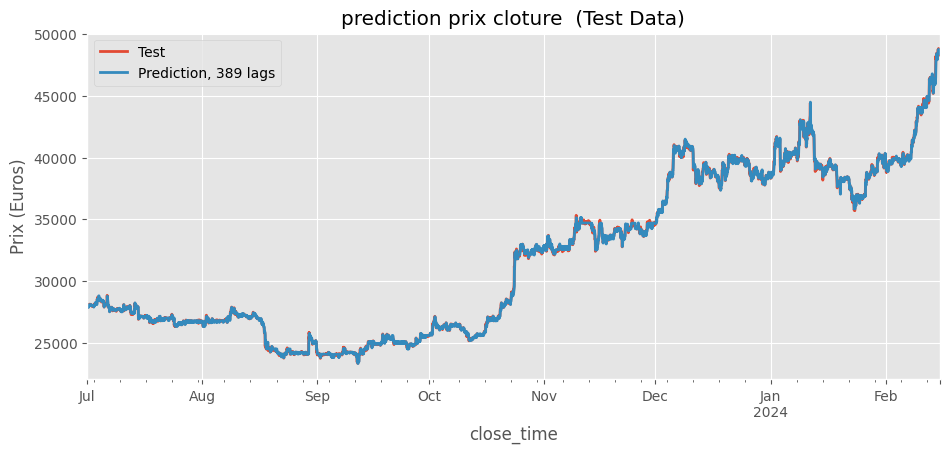

In [25]:
# les graphes 
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
df.loc[date_debut_test:, 'close'].plot(ax=ax, linewidth=2, label='Test')

# graphe prediction des tests avec les différents lags 
for predictions, lag in zip(predictions_list, lags):
    predictions = predictions.rename(columns={'pred': f'Prediction, {lag} lags'})
    
predictions.plot(ax=ax, linewidth=2)
    #print(predictions.head())

ax.set_title('prediction prix cloture  (Test Data)')
ax.set_ylabel('Prix (Euros)')
ax.legend();

**prédiction des 1000 prochaines heures**

In [8]:
# Prediction des valeurs futures avec le model
forecaster.fit(y=df['close'])
pred_price = forecaster.predict(steps=1000)
pred_price.loc['2024-02-15 20:00:0']

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99195
[LightGBM] [Info] Number of data points in the train set: 35709, number of used features: 389
[LightGBM] [Info] Start training from score 26437.835142


48300.325403916635

**Enregistrement du model dans un fichier**

In [9]:
import pickle
# enregistrer le model sur le disk
filename = 'forAutoreg_model.sav'
pickle.dump(forecaster, open(filename, 'wb'))
 

**rechargement du model enregistré**

In [10]:
# rechargement model
loaded_model = pickle.load(open(filename, 'rb'))

pred_price = loaded_model.predict(steps=100)
pred_price.loc['2024-02-15 20:00:00']

48300.325403916635